Data Preprocessing

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

print(os.cpu_count())

96


In [ ]:
!pip install netCDF4 h5netcdf xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.6 MB/s eta 0:00:00


In [ ]:
import netCDF4 as nc
import xarray as xr

# Open the NetCDF file using netCDF4
file_path = '/content/drive/MyDrive/STS/STSData/dataset-carbon-rep-monthly_multi-vars_179.88W-179.88E_88.12S-89.88N_2011-09-01-2022-12-01.nc'  # Replace with the path to your file
nc_dataset = nc.Dataset(file_path)

# Convert netCDF4.Dataset to xarray.Dataset
xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
ocs_df = xr_dataset.to_dataframe().reset_index()

In [ ]:
import pandas as pd
ta = ocs_df[['talk', 'latitude', 'longitude', 'time']]
del ocs_df
del nc_dataset
del xr_dataset
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')

In [ ]:
ta['yr'] = ta['time'].dt.year
ta['mn'] = ta['time'].dt.month
ta['month'] = (ta['yr'] - 2011) * 12 + ta['mn'] - 9
ta['longitude'] = (ta['longitude'] + 360) % 360
ta.drop(columns=['yr', 'mn'], inplace=True)

In [ ]:
print(ta.shape)
print(satellite_data.shape)

(139633920, 5)
(155520000, 10)


In [ ]:
ta = ta.dropna()
satellite_data = satellite_data.dropna()

In [ ]:
print(ta.shape)
print(satellite_data.shape)

(79787204, 5)
(66907461, 10)


In [ ]:
# when merging, remember that longitude ranges from 0-360 instead of smth else
merged_ta_df = pd.merge(ta, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')
del ta
del satellite_data

In [ ]:
import numpy as np
merged_ta_df['mn'] = merged_ta_df['month'] % 12
merged_ta_df['cmon'] = np.cos(np.deg2rad(merged_ta_df['mn']))
merged_ta_df['smon'] = np.sin(np.deg2rad(merged_ta_df['mn']))
merged_ta_df['clon'] = np.cos(np.deg2rad(merged_ta_df['longitude']))
merged_ta_df['slon'] = np.sin(np.deg2rad(merged_ta_df['longitude']))
merged_ta_df['pic/poc'] = merged_ta_df['pic']/merged_ta_df['poc']
merged_ta_df['logchla'] = np.log(merged_ta_df['chlor_a'] + 1e-5)

In [ ]:
merged_ta_df

,talk,latitude,longitude,time,month,sst,chlor_a,sss,poc,pic,u_wind,v_wind,mn,cmon,smon,clon,slon,pic/poc,logchla
0,2280.719971,-64.625,249.375,2011-09-01,0,0.440000,0.119880,33.823605,59.799805,0.000360,10.355253,3.067366,0,1.00000,0.000000,-0.352250,-0.935906,6.020039e-06,-2.121184
1,2279.691895,-64.375,250.125,2011-09-01,0,0.375000,0.127854,33.787605,51.399902,0.000144,10.368364,2.203864,0,1.00000,0.000000,-0.339969,-0.940437,2.801511e-06,-2.056788
2,2281.074463,-64.125,246.875,2011-09-01,0,0.235000,0.107158,33.830870,67.199710,0.000774,10.343028,1.087096,0,1.00000,0.000000,-0.392738,-0.919650,1.151785e-05,-2.233360
3,2278.772705,-64.125,255.625,2011-09-01,0,-0.630000,0.103240,33.833477,52.199707,0.000328,9.585847,2.037535,0,1.00000,0.000000,-0.248267,-0.968692,6.283501e-06,-2.270597
4,2278.703369,-64.125,255.875,2011-09-01,0,-0.830000,0.113233,33.840218,49.000000,0.000190,9.585847,2.037535,0,1.00000,0.000000,-0.244038,-0.969766,3.877495e-06,-2.178218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60530519,2329.666260,47.125,356.375,2022-12-01,135,13.875000,0.795078,35.295600,154.399900,0.000010,0.512892,9.786570,3,0.99863,0.052336,0.997999,-0.063226,6.475833e-08,-0.229303
60530520,2327.390381,47.375,355.875,2022-12-01,135,13.395000,0.949561,35.298150,169.600100,0.000010,-0.523360,9.986296,3,0.99863,0.052336,0.997409,-0.071933,5.895444e-08,-0.051745
60530521,2327.211182,47.375,356.125,2022-12-01,135,13.759999,0.990445,35.302296,170.000000,0.000042,-0.261769,9.996573,3,0.99863,0.052336,0.997714,-0.067580,2.470525e-07,-0.009591
60530522,2328.389404,47.375,356.375,2022-12-01,135,13.835000,1.030679,35.301792,195.799800,0.000926,-0.533827,10.186021,3,0.99863,0.052336,0.997999,-0.063226,4.729297e-06,0.030227


In [ ]:
test = merged_ta_df[merged_ta_df['time'].dt.year >= 2021]
validation = merged_ta_df[(merged_ta_df['time'].dt.year >= 2019) & (merged_ta_df['time'].dt.year < 2021)]
merged_ta_df = merged_ta_df[merged_ta_df['time'].dt.year < 2019]

Feature Selection

In [ ]:
X = merged_ta_df[['latitude', 'longitude', 'sst', 'chlor_a', 'sss', 'poc', 'pic', 'u_wind', 'v_wind', 'cmon', 'smon', 'clon', 'slon', 'mn', 'pic/poc', 'logchla']] # test with pic/poc, clon, slon, as well as month
y = merged_ta_df['talk']

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing and pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost (make sure xgboost is installed: pip install xgboost)
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Replace X and y with your actual data variables if different
# X = pd.DataFrame(...)  # Your features: Latitude, Longitude, SST, and SSS
# y = pd.Series(...)     # Your target variable: TA

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
X_train.shape

(48424419, 16)

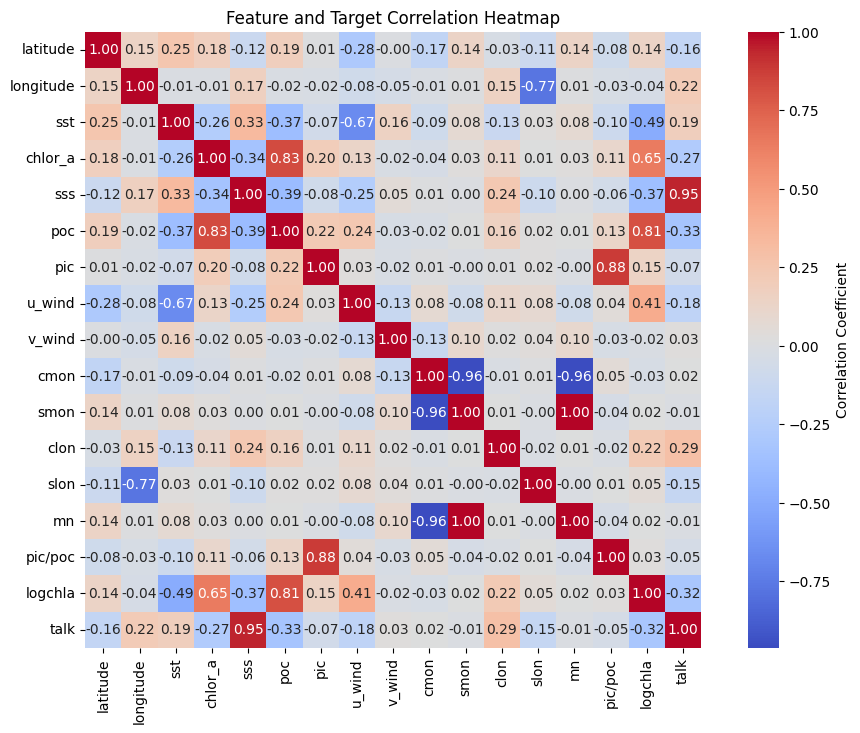

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and targets into a single DataFrame for correlation calculation
data_combined = pd.concat([X, y], axis=1)

# Calculate correlation matrix
correlation_matrix = data_combined.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature and Target Correlation Heatmap')
plt.show()

In [ ]:
correlation_matrix['talk']

,talk
latitude,-0.160081
longitude,0.217382
sst,0.186327
chlor_a,-0.271515
sss,0.945352
poc,-0.328841
pic,-0.066807
u_wind,-0.184424
v_wind,0.027750
cmon,0.018750


In [ ]:
sample_indices = X.sample(frac=0.05, random_state=42).index
X_sample = X.loc[sample_indices]
y_sample = y.loc[sample_indices]

# Basic Random Forest model for feature selection
rf = RandomForestRegressor(
    n_estimators=100,         # Enough trees for stable feature importance
    max_depth=15,             # Limit depth to avoid overfitting
    max_features='log2',      # Introduces randomness in splits, suitable for regression
    random_state=42,
    n_jobs=-1
)

rf.fit(X_sample, y_sample)

RandomForestRegressor(max_depth=15, max_features='log2', n_jobs=-1,
                      random_state=42)

In [ ]:
import pandas as pd

feature_importances = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)
print(feature_importances)

      feature  importance
4         sss    0.526898
0    latitude    0.122730
1   longitude    0.096302
11       clon    0.073528
2         sst    0.046362
12       slon    0.036947
5         poc    0.030591
15    logchla    0.019476
3     chlor_a    0.016146
7      u_wind    0.014146
10       smon    0.004098
13         mn    0.003653
8      v_wind    0.003248
9        cmon    0.002893
6         pic    0.002560
14    pic/poc    0.000421


sss, latitude, clon, slon, sst, logchla

In [ ]:
X_train = merged_ta_df[['latitude', 'sst', 'sss', 'longitude', 'poc']]
y_train = merged_ta_df['talk']
X_val = validation[['latitude', 'sst', 'sss', 'longitude', 'poc']]
y_val = validation['talk']
X_test = test[['latitude', 'sst', 'sss', 'longitude', 'poc']]
y_test = test['talk']

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.0 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing and pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost (make sure xgboost is installed: pip install xgboost)
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
sample_indices = X_train.sample(frac=0.05, random_state=42).index
X_sample = X_train.loc[sample_indices]
y_sample = y_train.loc[sample_indices]

In [ ]:
X_sample.shape

(1962880, 5)

In [ ]:
!pip install geopandas shapely cartopy

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

latitudes = X_sample['latitude']
longitudes = X_sample['longitude']

gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(longitudes, latitudes)])

gdf.plot(marker='o', color='blue', markersize=5, alpha=0.5)
plt.show()

KeyboardInterrupt: 

In [ ]:
!pip install tqdm

In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
import numpy as np

# Define the pipeline and parameter grid
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1, verbose=0))
])

param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Initialize variables to track the best model and score
best_score = float('inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_rf))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_rf.set_params(**params)

    # Perform cross-validation and get the mean score
    pipeline_rf.fit(X_sample, y_sample)
    mse, r2 = evaluate_model(pipeline_rf, X_train, y_train)
    print('Training MSE, R2: ')
    print(mse, r2)
    mse, r2 = evaluate_model(pipeline_rf, X_val, y_val)
    print('Validation MSE, R2: ')
    print(mse, r2)

    # Update the best model if the current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = pipeline_rf

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")
print(best_score)

Grid Search Progress:   0%|          | 0/24 [00:00<?, ?combination/s]

Training MSE, R2: 
79.97555427569611 0.9844334012001735


Grid Search Progress:   4%|▍         | 1/24 [01:41<39:02, 101.85s/combination, Best MSE=154]

Validation MSE, R2: 
153.55834593612164 0.9719450815846956
Training MSE, R2: 
79.49913922621725 0.9845261315601517


Grid Search Progress:   8%|▊         | 2/24 [04:08<47:03, 128.36s/combination, Best MSE=153]

Validation MSE, R2: 
153.13133959564303 0.9720230951109023
Training MSE, R2: 
80.62469964553291 0.9843070502717363


Grid Search Progress:  12%|█▎        | 3/24 [05:30<37:27, 107.04s/combination, Best MSE=153]

Validation MSE, R2: 
153.18642883367616 0.972013030375774
Training MSE, R2: 
80.19570070656022 0.984390551466933


Grid Search Progress:  17%|█▋        | 4/24 [07:39<38:37, 115.88s/combination, Best MSE=153]

Validation MSE, R2: 
152.8570652574413 0.9720732046906504
Training MSE, R2: 
80.57387761529738 0.9843169423714164


Grid Search Progress:  21%|██        | 5/24 [08:59<32:35, 102.93s/combination, Best MSE=153]

Validation MSE, R2: 
152.95486571286608 0.9720553366693377
Training MSE, R2: 
80.16188448370154 0.9843971335228991


Grid Search Progress:  25%|██▌       | 6/24 [11:06<33:20, 111.14s/combination, Best MSE=153]

Validation MSE, R2: 
152.58548726926057 0.9721228216506101
Training MSE, R2: 
80.84895293270965 0.9842634011719252


Grid Search Progress:  29%|██▉       | 7/24 [12:25<28:27, 100.42s/combination, Best MSE=153]

Validation MSE, R2: 
152.8778950220067 0.9720693991186254
Training MSE, R2: 
80.46028094497541 0.9843390530502096


Grid Search Progress:  33%|███▎      | 8/24 [14:28<28:42, 107.63s/combination, Best MSE=153]

Validation MSE, R2: 
152.56710779067157 0.972126179558441
Training MSE, R2: 
143.51704372146187 0.9720655610232128


Grid Search Progress:  38%|███▊      | 9/24 [15:08<21:40, 86.68s/combination, Best MSE=153] 

Validation MSE, R2: 
204.97387544526416 0.962551528425047
Training MSE, R2: 
143.48044198392034 0.9720726852572222


Grid Search Progress:  42%|████▏     | 10/24 [16:12<18:35, 79.65s/combination, Best MSE=153]

Validation MSE, R2: 
205.24924410427766 0.9625012189142506
Training MSE, R2: 
143.54181886366328 0.9720607387409249


Grid Search Progress:  46%|████▌     | 11/24 [16:51<14:33, 67.22s/combination, Best MSE=153]

Validation MSE, R2: 
204.98348680456402 0.962549772441682
Training MSE, R2: 
143.4978979643294 0.972069287590946


Grid Search Progress:  50%|█████     | 12/24 [17:54<13:09, 65.80s/combination, Best MSE=153]

Validation MSE, R2: 
205.233052311753 0.9625041771345643
Training MSE, R2: 
143.54253715615164 0.9720605989310657


Grid Search Progress:  54%|█████▍    | 13/24 [18:34<10:36, 57.90s/combination, Best MSE=153]

Validation MSE, R2: 
204.93614771769361 0.9625584212338523
Training MSE, R2: 
143.49825703264244 0.972069217701185


Grid Search Progress:  58%|█████▊    | 14/24 [19:37<09:54, 59.49s/combination, Best MSE=153]

Validation MSE, R2: 
205.204234576796 0.9625094420988239
Training MSE, R2: 
143.55247894862424 0.9720586638410725


Grid Search Progress:  62%|██████▎   | 15/24 [20:16<08:01, 53.50s/combination, Best MSE=153]

Validation MSE, R2: 
204.9203907493935 0.962561300012322
Training MSE, R2: 
143.50480739082397 0.9720679427266165


Grid Search Progress:  67%|██████▋   | 16/24 [21:19<07:30, 56.27s/combination, Best MSE=153]

Validation MSE, R2: 
205.14568567068275 0.9625201389109985
Training MSE, R2: 
84.69550385469734 0.983514700953365


Grid Search Progress:  71%|███████   | 17/24 [22:18<06:40, 57.18s/combination, Best MSE=152]

Validation MSE, R2: 
151.96586792934266 0.9722360253317515
Training MSE, R2: 
84.37225902344402 0.983577617961541


Grid Search Progress:  75%|███████▌  | 18/24 [23:52<06:49, 68.22s/combination, Best MSE=152]

Validation MSE, R2: 
151.7174913383532 0.9722814034253614
Training MSE, R2: 
85.1358000704597 0.9834290008340483


Grid Search Progress:  79%|███████▉  | 19/24 [24:51<05:27, 65.42s/combination, Best MSE=152]

Validation MSE, R2: 
151.82588161652222 0.972261600656632
Training MSE, R2: 
84.85755162265924 0.983483159657864


Grid Search Progress:  83%|████████▎ | 20/24 [26:25<04:56, 74.06s/combination, Best MSE=152]

Validation MSE, R2: 
151.7215682669421 0.9722806585755895
Training MSE, R2: 
84.97225804070322 0.9834608329755968


Grid Search Progress:  88%|████████▊ | 21/24 [27:26<03:30, 70.11s/combination, Best MSE=152]

Validation MSE, R2: 
151.71983153961563 0.9722809758735075
Training MSE, R2: 
84.66282718342157 0.9835210612047752


Grid Search Progress:  92%|█████████▏| 22/24 [29:02<02:35, 77.77s/combination, Best MSE=152]

Validation MSE, R2: 
151.5642104582986 0.972309407651106
Training MSE, R2: 
85.14572167765884 0.9834270696729563


Grid Search Progress:  96%|█████████▌| 23/24 [30:03<01:12, 72.66s/combination, Best MSE=152]

Validation MSE, R2: 
151.71039728984252 0.9722826994991827
Training MSE, R2: 
84.86316599645824 0.9834820668651321


Grid Search Progress: 100%|██████████| 24/24 [31:38<00:00, 79.12s/combination, Best MSE=152]

Validation MSE, R2: 
151.52575472104388 0.9723164334663732
Best MSE: 
151.52575472104388


In [ ]:
best_params

{'rf__max_depth': 20,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 200}

In [ ]:
# Fit the best model on the full training data and evaluate on the test set
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=67, verbose=1))
])
pipeline_rf.set_params(**best_params)
pipeline_rf.fit(X_train, y_train)
mse_RF, r2_RF = evaluate_model(pipeline_rf, X_train, y_train)
print(f"RF - MSE: {mse_RF:.4f}, R²: {r2_RF:.4f}")
mse_RF, r2_RF = evaluate_model(pipeline_rf, X_val, y_val)
print(f"RF - MSE: {mse_RF:.4f}, R²: {r2_RF:.4f}")
mse_RF, r2_RF = evaluate_model(pipeline_rf, X_test, y_test)
print(f"RF - MSE: {mse_RF:.4f}, R²: {r2_RF:.4f}")

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:  7.4min
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed: 18.7min finished
[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   12.8s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   27.0s finished


RF - MSE: 57.3114, R²: 0.9888


[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.1s finished


RF - MSE: 146.8233, R²: 0.9732


[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.2s finished


RF - MSE: 139.5726, R²: 0.9743


In [ ]:
import joblib
joblib.dump(pipeline_rf, '/content/drive/MyDrive/STS/rf_ta.joblib')

['/content/drive/MyDrive/STS/rf_ta.joblib']

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

best_score = float('-inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_knn))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_knn.set_params(**params)

    # Perform cross-validation and get the mean score
    scores = cross_val_score(pipeline_knn, X_sample, y_sample, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=3)
    mean_score = np.mean(scores)

    # Update the best model if the current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = pipeline_knn

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': -best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")
print(best_score)

Grid Search Progress:   0%|          | 0/6 [00:00<?, ?combination/s]

[CV] END ............................. score: (test=-149.536) total time=  12.9s
[CV] END ............................. score: (test=-150.540) total time=  13.2s
[CV] END ............................. score: (test=-150.471) total time=  12.1s
[CV] END ............................. score: (test=-151.014) total time=  11.9s


Grid Search Progress:  17%|█▋        | 1/6 [01:02<05:10, 62.17s/combination, Best MSE=149]

[CV] END ............................. score: (test=-142.400) total time=  12.1s
[CV] END ............................. score: (test=-147.541) total time=  13.7s
[CV] END ............................. score: (test=-147.899) total time=  13.7s
[CV] END ............................. score: (test=-147.234) total time=  10.0s
[CV] END ............................. score: (test=-148.308) total time=   9.9s


Grid Search Progress:  33%|███▎      | 2/6 [01:59<03:57, 59.32s/combination, Best MSE=146]

[CV] END ............................. score: (test=-140.902) total time=  10.0s
[CV] END ............................. score: (test=-141.765) total time=  11.3s
[CV] END ............................. score: (test=-142.169) total time=  11.6s
[CV] END ............................. score: (test=-141.148) total time=  11.5s
[CV] END ............................. score: (test=-143.001) total time=  11.4s


Grid Search Progress:  50%|█████     | 3/6 [02:59<02:58, 59.59s/combination, Best MSE=141]

[CV] END ............................. score: (test=-135.392) total time=  13.9s
[CV] END ............................. score: (test=-138.304) total time=  13.2s
[CV] END ............................. score: (test=-138.262) total time=  13.0s
[CV] END ............................. score: (test=-137.145) total time=  13.0s
[CV] END ............................. score: (test=-139.077) total time=  13.1s


Grid Search Progress:  67%|██████▋   | 4/6 [04:04<02:03, 61.91s/combination, Best MSE=137]

[CV] END ............................. score: (test=-132.276) total time=  13.1s
[CV] END ............................. score: (test=-139.594) total time=  17.0s
[CV] END ............................. score: (test=-139.792) total time=  17.0s
[CV] END ............................. score: (test=-139.487) total time=  16.9s
[CV] END ............................. score: (test=-141.969) total time=  17.1s


Grid Search Progress:  83%|████████▎ | 5/6 [05:25<01:08, 68.58s/combination, Best MSE=137]

[CV] END ............................. score: (test=-133.997) total time=  12.3s
[CV] END ............................. score: (test=-135.349) total time=  19.2s
[CV] END ............................. score: (test=-134.967) total time=  17.6s
[CV] END ............................. score: (test=-134.696) total time=  17.6s
[CV] END ............................. score: (test=-137.015) total time=  16.8s


Grid Search Progress: 100%|██████████| 6/6 [06:53<00:00, 68.90s/combination, Best MSE=134]

[CV] END ............................. score: (test=-129.874) total time=  16.9s
Best MSE: 
-134.38011022714426


In [ ]:
best_params = {'knn__n_neighbors': 7, 'knn__weights': 'distance'}

In [ ]:
# Fit the best model on the full training data and evaluate on the test set
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])
pipeline_knn.set_params(**best_params)
pipeline_knn.fit(X_train, y_train)
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_train, y_train)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_val, y_val)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_test, y_test)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")

knn - MSE: 0.0000, R²: 1.0000
knn - MSE: 206.3235, R²: 0.9623
knn - MSE: 184.3690, R²: 0.9660


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/STS/knn_ta.joblib')

In [ ]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Fit the model
pipeline_lr.fit(X_train, y_train)

# Evaluate
mse_lr, r2_lr = evaluate_model(pipeline_lr, X_test, y_test)
print(f"Linear Regression - MSE: {mse_lr:.4f}, R²: {r2_lr:.4f}")

Linear Regression - MSE: 423.4882, R²: 0.9186


In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
import numpy as np
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

param_grid_xgb = {
    'xgb__n_estimators': [100, 200],             # Number of boosting rounds
    'xgb__max_depth': [3, 6],                    # Maximum depth of a tree
    'xgb__learning_rate': [0.05, 0.1],           # Step size shrinkage
    'xgb__subsample': [0.8, 1.0],                # Fraction of samples for each boosting round
    'xgb__colsample_bytree': [0.8, 1.0],         # Fraction of features used per tree
    'xgb__min_child_weight': [1, 5],             # Minimum sum of instance weight for leaf nodes
    'xgb__gamma': [0, 0.1],                      # Minimum loss reduction for partitioning
}

best_score = float('inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_xgb))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_xgb.set_params(**params)

    pipeline_xgb.fit(X_sample, y_sample)
    mse, r2 = evaluate_model(pipeline_xgb, X_train, y_train)
    print('Training MSE, R2: ')
    print(mse, r2)
    mse, r2 = evaluate_model(pipeline_xgb, X_val, y_val)
    print('Validation MSE, R2: ')
    print(mse, r2)

    # Update the best model if the current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = pipeline_xgb

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")


Grid Search Progress:   0%|          | 0/128 [00:13<?, ?combination/s]


Training MSE, R2: 
278.6413 0.9457647204399109



Grid Search Progress:   1%|          | 1/128 [00:05<10:58,  5.18s/combination, Best MSE=364]

Validation MSE, R2: 
363.50867 0.9335874319076538
Training MSE, R2: 
278.52042 0.9457882046699524



Grid Search Progress:   2%|▏         | 2/128 [00:10<11:03,  5.27s/combination, Best MSE=360]

Validation MSE, R2: 
359.58374 0.9343044757843018
Training MSE, R2: 
232.744 0.9546982645988464



Grid Search Progress:   2%|▏         | 3/128 [00:20<15:06,  7.25s/combination, Best MSE=310]

Validation MSE, R2: 
310.39542 0.9432911276817322
Training MSE, R2: 
231.39749 0.9549603462219238



Grid Search Progress:   3%|▎         | 4/128 [00:27<14:58,  7.25s/combination, Best MSE=308]

Validation MSE, R2: 
308.0743 0.9437152147293091
Training MSE, R2: 
278.6413 0.9457647204399109



Grid Search Progress:   4%|▍         | 5/128 [00:32<13:16,  6.47s/combination, Best MSE=308]

Validation MSE, R2: 
363.50867 0.9335874319076538
Training MSE, R2: 
278.52042 0.9457882046699524



Grid Search Progress:   5%|▍         | 6/128 [00:37<12:04,  5.94s/combination, Best MSE=308]

Validation MSE, R2: 
359.58374 0.9343044757843018
Training MSE, R2: 
232.744 0.9546982645988464



Grid Search Progress:   5%|▌         | 7/128 [00:50<16:54,  8.38s/combination, Best MSE=308]

Validation MSE, R2: 
310.39542 0.9432911276817322
Training MSE, R2: 
231.39749 0.9549603462219238



Grid Search Progress:   6%|▋         | 8/128 [01:02<18:44,  9.37s/combination, Best MSE=308]

Validation MSE, R2: 
308.0743 0.9437152147293091
Training MSE, R2: 
153.27339 0.9701665639877319



Grid Search Progress:   7%|▋         | 9/128 [01:09<17:03,  8.60s/combination, Best MSE=215]

Validation MSE, R2: 
215.36778 0.9606525897979736
Training MSE, R2: 
153.82872 0.9700584411621094



Grid Search Progress:   8%|▊         | 10/128 [01:15<15:44,  8.01s/combination, Best MSE=215]

Validation MSE, R2: 
215.98737 0.9605394005775452
Training MSE, R2: 
129.73251 0.9747486114501953



Grid Search Progress:   9%|▊         | 11/128 [01:29<19:11,  9.84s/combination, Best MSE=185]

Validation MSE, R2: 
184.841 0.9662297964096069
Training MSE, R2: 
131.77138 0.9743517637252808



Grid Search Progress:   9%|▉         | 12/128 [01:40<19:16,  9.97s/combination, Best MSE=185]

Validation MSE, R2: 
188.6434 0.9655351042747498
Training MSE, R2: 
153.29135 0.9701630473136902



Grid Search Progress:  10%|█         | 13/128 [01:46<17:11,  8.97s/combination, Best MSE=185]

Validation MSE, R2: 
215.35616 0.9606547355651855
Training MSE, R2: 
152.93231 0.9702329635620117



Grid Search Progress:  11%|█         | 14/128 [01:53<15:50,  8.33s/combination, Best MSE=185]

Validation MSE, R2: 
215.10254 0.960701048374176
Training MSE, R2: 
130.46288 0.974606454372406



Grid Search Progress:  12%|█▏        | 15/128 [02:03<16:45,  8.90s/combination, Best MSE=185]

Validation MSE, R2: 
185.54906 0.9661004543304443
Training MSE, R2: 
130.758 0.9745489954948425



Grid Search Progress:  12%|█▎        | 16/128 [02:16<18:55, 10.13s/combination, Best MSE=185]

Validation MSE, R2: 
186.38162 0.9659483432769775
Training MSE, R2: 
230.77563 0.9550813436508179



Grid Search Progress:  13%|█▎        | 17/128 [02:24<17:33,  9.49s/combination, Best MSE=185]

Validation MSE, R2: 
310.3287 0.9433033466339111
Training MSE, R2: 
233.94392 0.9544646739959717



Grid Search Progress:  14%|█▍        | 18/128 [02:29<14:59,  8.18s/combination, Best MSE=185]

Validation MSE, R2: 
315.0324 0.9424439668655396
Training MSE, R2: 
197.1575 0.9616248607635498



Grid Search Progress:  15%|█▍        | 19/128 [02:42<17:12,  9.47s/combination, Best MSE=185]

Validation MSE, R2: 
266.08466 0.9513866901397705
Training MSE, R2: 
199.80334 0.9611098766326904



Grid Search Progress:  16%|█▌        | 20/128 [02:49<15:35,  8.66s/combination, Best MSE=185]

Validation MSE, R2: 
272.5162 0.9502116441726685
Training MSE, R2: 
230.77563 0.9550813436508179



Grid Search Progress:  16%|█▋        | 21/128 [02:54<13:37,  7.64s/combination, Best MSE=185]

Validation MSE, R2: 
310.3287 0.9433033466339111
Training MSE, R2: 
233.94392 0.9544646739959717



Grid Search Progress:  17%|█▋        | 22/128 [02:59<12:06,  6.86s/combination, Best MSE=185]

Validation MSE, R2: 
315.0324 0.9424439668655396
Training MSE, R2: 
197.1586 0.9616246819496155



Grid Search Progress:  18%|█▊        | 23/128 [03:09<13:40,  7.82s/combination, Best MSE=185]

Validation MSE, R2: 
266.08398 0.9513868093490601
Training MSE, R2: 
199.80408 0.9611097574234009



Grid Search Progress:  19%|█▉        | 24/128 [03:16<13:00,  7.51s/combination, Best MSE=185]

Validation MSE, R2: 
272.5154 0.950211763381958
Training MSE, R2: 
130.42937 0.9746129512786865



Grid Search Progress:  20%|█▉        | 25/128 [03:23<12:28,  7.27s/combination, Best MSE=185]

Validation MSE, R2: 
188.17381 0.9656208753585815
Training MSE, R2: 
130.51491 0.9745963215827942



Grid Search Progress:  20%|██        | 26/128 [03:30<12:20,  7.26s/combination, Best MSE=185]

Validation MSE, R2: 
186.94733 0.965844988822937
Training MSE, R2: 
115.891945 0.9774425625801086



Grid Search Progress:  21%|██        | 27/128 [03:40<13:28,  8.00s/combination, Best MSE=169]

Validation MSE, R2: 
169.31187 0.9690669178962708
Training MSE, R2: 
115.69645 0.9774805903434753



Grid Search Progress:  22%|██▏       | 28/128 [03:52<15:46,  9.47s/combination, Best MSE=169]

Validation MSE, R2: 
168.69313 0.9691799879074097
Training MSE, R2: 
130.0201 0.9746926426887512



Grid Search Progress:  23%|██▎       | 29/128 [04:03<16:22,  9.92s/combination, Best MSE=169]

Validation MSE, R2: 
187.44829 0.965753436088562
Training MSE, R2: 
130.35492 0.9746274352073669



Grid Search Progress:  23%|██▎       | 30/128 [04:10<14:34,  8.93s/combination, Best MSE=169]

Validation MSE, R2: 
186.55363 0.9659168720245361
Training MSE, R2: 
115.85556 0.9774496555328369



Grid Search Progress:  24%|██▍       | 31/128 [04:22<15:44,  9.74s/combination, Best MSE=168]

Validation MSE, R2: 
168.26091 0.9692589640617371
Training MSE, R2: 
116.12109 0.9773979783058167



Grid Search Progress:  25%|██▌       | 32/128 [04:36<17:41, 11.06s/combination, Best MSE=168]

Validation MSE, R2: 
169.51103 0.9690305590629578
Training MSE, R2: 
278.6413 0.9457647204399109



Grid Search Progress:  26%|██▌       | 33/128 [04:41<14:40,  9.27s/combination, Best MSE=168]

Validation MSE, R2: 
363.50867 0.9335874319076538
Training MSE, R2: 
278.52042 0.9457882046699524



Grid Search Progress:  27%|██▋       | 34/128 [04:46<12:41,  8.11s/combination, Best MSE=168]

Validation MSE, R2: 
359.58374 0.9343044757843018
Training MSE, R2: 
232.744 0.9546982645988464



Grid Search Progress:  27%|██▋       | 35/128 [04:53<12:08,  7.83s/combination, Best MSE=168]

Validation MSE, R2: 
310.39542 0.9432911276817322
Training MSE, R2: 
231.39749 0.9549603462219238



Grid Search Progress:  28%|██▊       | 36/128 [05:02<12:15,  8.00s/combination, Best MSE=168]

Validation MSE, R2: 
308.0743 0.9437152147293091
Training MSE, R2: 
278.6413 0.9457647204399109



Grid Search Progress:  29%|██▉       | 37/128 [05:07<10:45,  7.09s/combination, Best MSE=168]

Validation MSE, R2: 
363.50867 0.9335874319076538
Training MSE, R2: 
278.52042 0.9457882046699524



Grid Search Progress:  30%|██▉       | 38/128 [05:14<10:27,  6.98s/combination, Best MSE=168]

Validation MSE, R2: 
359.58374 0.9343044757843018
Training MSE, R2: 
232.744 0.9546982645988464



Grid Search Progress:  30%|███       | 39/128 [05:20<10:19,  6.96s/combination, Best MSE=168]

Validation MSE, R2: 
310.39542 0.9432911276817322
Training MSE, R2: 
231.39749 0.9549603462219238



Grid Search Progress:  31%|███▏      | 40/128 [05:30<11:10,  7.62s/combination, Best MSE=168]

Validation MSE, R2: 
308.0743 0.9437152147293091
Training MSE, R2: 
153.27339 0.9701665639877319



Grid Search Progress:  32%|███▏      | 41/128 [05:37<10:51,  7.49s/combination, Best MSE=168]

Validation MSE, R2: 
215.36778 0.9606525897979736
Training MSE, R2: 
153.82872 0.9700584411621094



Grid Search Progress:  33%|███▎      | 42/128 [05:44<10:32,  7.36s/combination, Best MSE=168]

Validation MSE, R2: 
215.98737 0.9605394005775452
Training MSE, R2: 
129.73251 0.9747486114501953



Grid Search Progress:  34%|███▎      | 43/128 [05:54<11:46,  8.32s/combination, Best MSE=168]

Validation MSE, R2: 
184.841 0.9662297964096069
Training MSE, R2: 
131.77138 0.9743517637252808



Grid Search Progress:  34%|███▍      | 44/128 [06:06<12:52,  9.20s/combination, Best MSE=168]

Validation MSE, R2: 
188.6434 0.9655351042747498
Training MSE, R2: 
153.29135 0.9701630473136902



Grid Search Progress:  35%|███▌      | 45/128 [06:13<11:50,  8.56s/combination, Best MSE=168]

Validation MSE, R2: 
215.35616 0.9606547355651855
Training MSE, R2: 
152.93231 0.9702329635620117



Grid Search Progress:  36%|███▌      | 46/128 [06:20<11:02,  8.08s/combination, Best MSE=168]

Validation MSE, R2: 
215.10254 0.960701048374176
Training MSE, R2: 
130.46288 0.974606454372406



Grid Search Progress:  37%|███▋      | 47/128 [06:30<11:53,  8.81s/combination, Best MSE=168]

Validation MSE, R2: 
185.54906 0.9661004543304443
Training MSE, R2: 
130.758 0.9745489954948425



Grid Search Progress:  38%|███▊      | 48/128 [06:44<13:34, 10.18s/combination, Best MSE=168]

Validation MSE, R2: 
186.38162 0.9659483432769775
Training MSE, R2: 
230.77563 0.9550813436508179



Grid Search Progress:  38%|███▊      | 49/128 [06:49<11:30,  8.74s/combination, Best MSE=168]

Validation MSE, R2: 
310.3287 0.9433033466339111
Training MSE, R2: 
233.94392 0.9544646739959717



Grid Search Progress:  39%|███▉      | 50/128 [06:54<09:55,  7.64s/combination, Best MSE=168]

Validation MSE, R2: 
315.0324 0.9424439668655396
Training MSE, R2: 
197.1575 0.9616248607635498



Grid Search Progress:  40%|███▉      | 51/128 [07:01<09:34,  7.46s/combination, Best MSE=168]

Validation MSE, R2: 
266.08466 0.9513866901397705
Training MSE, R2: 
199.80334 0.9611098766326904



Grid Search Progress:  41%|████      | 52/128 [07:10<09:55,  7.83s/combination, Best MSE=168]

Validation MSE, R2: 
272.5162 0.9502116441726685
Training MSE, R2: 
230.77563 0.9550813436508179



Grid Search Progress:  41%|████▏     | 53/128 [07:15<08:50,  7.07s/combination, Best MSE=168]

Validation MSE, R2: 
310.3287 0.9433033466339111
Training MSE, R2: 
233.94392 0.9544646739959717



Grid Search Progress:  42%|████▏     | 54/128 [07:20<07:57,  6.45s/combination, Best MSE=168]

Validation MSE, R2: 
315.0324 0.9424439668655396
Training MSE, R2: 
197.1586 0.9616246819496155



Grid Search Progress:  43%|████▎     | 55/128 [07:27<08:02,  6.61s/combination, Best MSE=168]

Validation MSE, R2: 
266.08398 0.9513868093490601
Training MSE, R2: 
199.80408 0.9611097574234009



Grid Search Progress:  44%|████▍     | 56/128 [07:35<08:28,  7.06s/combination, Best MSE=168]

Validation MSE, R2: 
272.5154 0.950211763381958
Training MSE, R2: 
130.42937 0.9746129512786865



Grid Search Progress:  45%|████▍     | 57/128 [07:42<08:20,  7.06s/combination, Best MSE=168]

Validation MSE, R2: 
188.17381 0.9656208753585815
Training MSE, R2: 
130.51491 0.9745963215827942



Grid Search Progress:  45%|████▌     | 58/128 [07:49<08:09,  6.99s/combination, Best MSE=168]

Validation MSE, R2: 
186.94733 0.965844988822937
Training MSE, R2: 
115.89194 0.9774425625801086



Grid Search Progress:  46%|████▌     | 59/128 [07:59<09:09,  7.96s/combination, Best MSE=168]

Validation MSE, R2: 
169.31189 0.9690669178962708
Training MSE, R2: 
115.69645 0.9774805903434753



Grid Search Progress:  47%|████▋     | 60/128 [08:10<09:52,  8.71s/combination, Best MSE=168]

Validation MSE, R2: 
168.69313 0.9691799879074097
Training MSE, R2: 
130.0201 0.9746926426887512



Grid Search Progress:  48%|████▊     | 61/128 [08:17<09:16,  8.31s/combination, Best MSE=168]

Validation MSE, R2: 
187.44829 0.965753436088562
Training MSE, R2: 
130.35492 0.9746274352073669



Grid Search Progress:  48%|████▊     | 62/128 [08:24<08:37,  7.84s/combination, Best MSE=168]

Validation MSE, R2: 
186.55363 0.9659168720245361
Training MSE, R2: 
115.85556 0.9774496555328369



Grid Search Progress:  49%|████▉     | 63/128 [08:35<09:38,  8.90s/combination, Best MSE=168]

Validation MSE, R2: 
168.26091 0.9692589640617371
Training MSE, R2: 
116.12109 0.9773979783058167



Grid Search Progress:  50%|█████     | 64/128 [08:47<10:27,  9.81s/combination, Best MSE=168]

Validation MSE, R2: 
169.51103 0.9690305590629578
Training MSE, R2: 
254.63963 0.9504364132881165



Grid Search Progress:  51%|█████     | 65/128 [08:56<10:02,  9.57s/combination, Best MSE=168]

Validation MSE, R2: 
334.78085 0.9388359785079956
Training MSE, R2: 
253.97522 0.950565755367279



Grid Search Progress:  52%|█████▏    | 66/128 [09:01<08:26,  8.17s/combination, Best MSE=168]

Validation MSE, R2: 
333.78046 0.939018726348877
Training MSE, R2: 
218.03468 0.9575613141059875



Grid Search Progress:  52%|█████▏    | 67/128 [09:11<08:55,  8.77s/combination, Best MSE=168]

Validation MSE, R2: 
290.66238 0.9468963742256165
Training MSE, R2: 
218.8427 0.9574040174484253



Grid Search Progress:  53%|█████▎    | 68/128 [09:18<08:09,  8.16s/combination, Best MSE=168]

Validation MSE, R2: 
292.08142 0.9466370940208435
Training MSE, R2: 
254.63963 0.9504364132881165



Grid Search Progress:  54%|█████▍    | 69/128 [09:26<07:51,  7.99s/combination, Best MSE=168]

Validation MSE, R2: 
334.78085 0.9388359785079956
Training MSE, R2: 
253.97522 0.950565755367279



Grid Search Progress:  55%|█████▍    | 70/128 [09:31<06:52,  7.11s/combination, Best MSE=168]

Validation MSE, R2: 
333.78046 0.939018726348877
Training MSE, R2: 
218.03468 0.9575613141059875



Grid Search Progress:  55%|█████▌    | 71/128 [09:41<07:46,  8.19s/combination, Best MSE=168]

Validation MSE, R2: 
290.66238 0.9468963742256165
Training MSE, R2: 
218.8427 0.9574040174484253



Grid Search Progress:  56%|█████▋    | 72/128 [09:48<07:15,  7.78s/combination, Best MSE=168]

Validation MSE, R2: 
292.08142 0.9466370940208435
Training MSE, R2: 
149.19682 0.9709600210189819



Grid Search Progress:  57%|█████▋    | 73/128 [09:55<06:58,  7.60s/combination, Best MSE=168]

Validation MSE, R2: 
207.56024 0.9620789885520935
Training MSE, R2: 
149.13367 0.9709722995758057



Grid Search Progress:  58%|█████▊    | 74/128 [10:02<06:40,  7.41s/combination, Best MSE=168]

Validation MSE, R2: 
207.27493 0.962131142616272
Training MSE, R2: 
127.955894 0.9750944375991821



Grid Search Progress:  59%|█████▊    | 75/128 [10:12<07:14,  8.20s/combination, Best MSE=168]

Validation MSE, R2: 
182.22809 0.966707170009613
Training MSE, R2: 
127.70173 0.9751439094543457



Grid Search Progress:  59%|█████▉    | 76/128 [10:26<08:33,  9.87s/combination, Best MSE=168]

Validation MSE, R2: 
182.26735 0.9666999578475952
Training MSE, R2: 
149.54858 0.9708915948867798



Grid Search Progress:  60%|██████    | 77/128 [10:37<08:39, 10.18s/combination, Best MSE=168]

Validation MSE, R2: 
208.02885 0.961993396282196
Training MSE, R2: 
150.04561 0.9707947969436646



Grid Search Progress:  61%|██████    | 78/128 [10:44<07:40,  9.22s/combination, Best MSE=168]

Validation MSE, R2: 
208.21681 0.9619590640068054
Training MSE, R2: 
126.8601 0.9753077030181885



Grid Search Progress:  62%|██████▏   | 79/128 [10:55<07:52,  9.65s/combination, Best MSE=168]

Validation MSE, R2: 
181.45586 0.9668482542037964
Training MSE, R2: 
127.562546 0.9751709699630737



Grid Search Progress:  62%|██████▎   | 80/128 [11:09<08:55, 11.16s/combination, Best MSE=168]

Validation MSE, R2: 
181.88945 0.9667690396308899
Training MSE, R2: 
219.2012 0.9573342204093933



Grid Search Progress:  63%|██████▎   | 81/128 [11:17<08:01, 10.24s/combination, Best MSE=168]

Validation MSE, R2: 
294.4154 0.9462106823921204
Training MSE, R2: 
217.63289 0.9576395153999329



Grid Search Progress:  64%|██████▍   | 82/128 [11:22<06:36,  8.63s/combination, Best MSE=168]

Validation MSE, R2: 
289.8258 0.9470492005348206
Training MSE, R2: 
190.2246 0.9629743099212646



Grid Search Progress:  65%|██████▍   | 83/128 [11:34<07:11,  9.60s/combination, Best MSE=168]

Validation MSE, R2: 
257.94806 0.9528732299804688
Training MSE, R2: 
190.71066 0.9628797173500061



Grid Search Progress:  66%|██████▌   | 84/128 [11:41<06:27,  8.80s/combination, Best MSE=168]

Validation MSE, R2: 
257.7438 0.9529105424880981
Training MSE, R2: 
219.2012 0.9573342204093933



Grid Search Progress:  66%|██████▋   | 85/128 [11:46<05:31,  7.70s/combination, Best MSE=168]

Validation MSE, R2: 
294.4154 0.9462106823921204
Training MSE, R2: 
217.63289 0.9576395153999329



Grid Search Progress:  67%|██████▋   | 86/128 [11:51<04:49,  6.90s/combination, Best MSE=168]

Validation MSE, R2: 
289.8258 0.9470492005348206
Training MSE, R2: 
190.2246 0.9629743099212646



Grid Search Progress:  68%|██████▊   | 87/128 [12:01<05:21,  7.85s/combination, Best MSE=168]

Validation MSE, R2: 
257.94806 0.9528732299804688
Training MSE, R2: 
190.71066 0.9628797173500061



Grid Search Progress:  69%|██████▉   | 88/128 [12:08<05:04,  7.62s/combination, Best MSE=168]

Validation MSE, R2: 
257.7438 0.9529105424880981
Training MSE, R2: 
128.0836 0.975069522857666



Grid Search Progress:  70%|██████▉   | 89/128 [12:15<04:50,  7.45s/combination, Best MSE=168]

Validation MSE, R2: 
182.52972 0.9666520357131958
Training MSE, R2: 
127.11857 0.975257396697998



Grid Search Progress:  70%|███████   | 90/128 [12:22<04:38,  7.32s/combination, Best MSE=168]

Validation MSE, R2: 
181.32292 0.96687251329422
Training MSE, R2: 
114.13074 0.9777853488922119



Grid Search Progress:  71%|███████   | 91/128 [12:33<05:09,  8.36s/combination, Best MSE=167]

Validation MSE, R2: 
167.17285 0.969457745552063
Training MSE, R2: 
114.119255 0.9777876138687134



Grid Search Progress:  72%|███████▏  | 92/128 [12:45<05:42,  9.50s/combination, Best MSE=167]

Validation MSE, R2: 
167.14407 0.9694629907608032
Training MSE, R2: 
127.254555 0.9752309322357178



Grid Search Progress:  73%|███████▎  | 93/128 [12:56<05:39,  9.70s/combination, Best MSE=167]

Validation MSE, R2: 
181.21112 0.9668929576873779
Training MSE, R2: 
127.17059 0.9752472639083862



Grid Search Progress:  73%|███████▎  | 94/128 [13:02<04:59,  8.82s/combination, Best MSE=167]

Validation MSE, R2: 
181.30386 0.9668760299682617
Training MSE, R2: 
113.89693 0.9778308868408203



Grid Search Progress:  74%|███████▍  | 95/128 [13:15<05:25,  9.87s/combination, Best MSE=166]

Validation MSE, R2: 
166.49176 0.9695821404457092
Training MSE, R2: 
113.754234 0.9778586626052856



Grid Search Progress:  75%|███████▌  | 96/128 [13:49<09:13, 17.31s/combination, Best MSE=166]

Validation MSE, R2: 
166.92603 0.9695028066635132
Training MSE, R2: 
254.63963 0.9504364132881165



Grid Search Progress:  76%|███████▌  | 97/128 [13:56<07:14, 14.01s/combination, Best MSE=166]

Validation MSE, R2: 
334.78085 0.9388359785079956
Training MSE, R2: 
253.97522 0.950565755367279



Grid Search Progress:  77%|███████▋  | 98/128 [14:01<05:40, 11.35s/combination, Best MSE=166]

Validation MSE, R2: 
333.78046 0.939018726348877
Training MSE, R2: 
218.03468 0.9575613141059875



Grid Search Progress:  77%|███████▋  | 99/128 [14:08<04:49,  9.98s/combination, Best MSE=166]

Validation MSE, R2: 
290.66238 0.9468963742256165
Training MSE, R2: 
218.8427 0.9574040174484253



Grid Search Progress:  78%|███████▊  | 100/128 [14:15<04:14,  9.10s/combination, Best MSE=166]

Validation MSE, R2: 
292.08142 0.9466370940208435
Training MSE, R2: 
254.63963 0.9504364132881165



Grid Search Progress:  79%|███████▉  | 101/128 [14:20<03:33,  7.89s/combination, Best MSE=166]

Validation MSE, R2: 
334.78085 0.9388359785079956
Training MSE, R2: 
253.97522 0.950565755367279



Grid Search Progress:  80%|███████▉  | 102/128 [14:25<03:03,  7.07s/combination, Best MSE=166]

Validation MSE, R2: 
333.78046 0.939018726348877
Training MSE, R2: 
218.03468 0.9575613141059875



Grid Search Progress:  80%|████████  | 103/128 [14:33<03:06,  7.44s/combination, Best MSE=166]

Validation MSE, R2: 
290.66238 0.9468963742256165
Training MSE, R2: 
218.8427 0.9574040174484253



Grid Search Progress:  81%|████████▏ | 104/128 [14:40<02:54,  7.29s/combination, Best MSE=166]

Validation MSE, R2: 
292.08142 0.9466370940208435
Training MSE, R2: 
149.19682 0.9709600210189819



Grid Search Progress:  82%|████████▏ | 105/128 [14:48<02:49,  7.38s/combination, Best MSE=166]

Validation MSE, R2: 
207.56024 0.9620789885520935
Training MSE, R2: 
149.13367 0.9709722995758057



Grid Search Progress:  83%|████████▎ | 106/128 [14:55<02:42,  7.37s/combination, Best MSE=166]

Validation MSE, R2: 
207.27493 0.962131142616272
Training MSE, R2: 
127.955894 0.9750944375991821



Grid Search Progress:  84%|████████▎ | 107/128 [15:05<02:53,  8.27s/combination, Best MSE=166]

Validation MSE, R2: 
182.22809 0.966707170009613
Training MSE, R2: 
127.70173 0.9751439094543457



Grid Search Progress:  84%|████████▍ | 108/128 [15:18<03:12,  9.65s/combination, Best MSE=166]

Validation MSE, R2: 
182.26735 0.9666999578475952
Training MSE, R2: 
149.54858 0.9708915948867798



Grid Search Progress:  85%|████████▌ | 109/128 [15:29<03:10, 10.00s/combination, Best MSE=166]

Validation MSE, R2: 
208.02885 0.961993396282196
Training MSE, R2: 
150.04561 0.9707947969436646



Grid Search Progress:  86%|████████▌ | 110/128 [15:36<02:44,  9.16s/combination, Best MSE=166]

Validation MSE, R2: 
208.21681 0.9619590640068054
Training MSE, R2: 
126.8601 0.9753077030181885



Grid Search Progress:  87%|████████▋ | 111/128 [15:47<02:42,  9.56s/combination, Best MSE=166]

Validation MSE, R2: 
181.45586 0.9668482542037964
Training MSE, R2: 
127.562546 0.9751709699630737



Grid Search Progress:  88%|████████▊ | 112/128 [15:59<02:47, 10.47s/combination, Best MSE=166]

Validation MSE, R2: 
181.88945 0.9667690396308899
Training MSE, R2: 
219.2012 0.9573342204093933



Grid Search Progress:  88%|████████▊ | 113/128 [16:08<02:26,  9.77s/combination, Best MSE=166]

Validation MSE, R2: 
294.4154 0.9462106823921204
Training MSE, R2: 
217.63289 0.9576395153999329



Grid Search Progress:  89%|████████▉ | 114/128 [16:12<01:56,  8.30s/combination, Best MSE=166]

Validation MSE, R2: 
289.8258 0.9470492005348206
Training MSE, R2: 
190.2246 0.9629743099212646



Grid Search Progress:  90%|████████▉ | 115/128 [16:19<01:42,  7.91s/combination, Best MSE=166]

Validation MSE, R2: 
257.94806 0.9528732299804688
Training MSE, R2: 
190.71066 0.9628797173500061



Grid Search Progress:  91%|█████████ | 116/128 [16:26<01:30,  7.54s/combination, Best MSE=166]

Validation MSE, R2: 
257.7438 0.9529105424880981
Training MSE, R2: 
219.2012 0.9573342204093933



Grid Search Progress:  91%|█████████▏| 117/128 [16:31<01:14,  6.81s/combination, Best MSE=166]

Validation MSE, R2: 
294.4154 0.9462106823921204
Training MSE, R2: 
217.63289 0.9576395153999329



Grid Search Progress:  92%|█████████▏| 118/128 [16:36<01:03,  6.36s/combination, Best MSE=166]

Validation MSE, R2: 
289.8258 0.9470492005348206
Training MSE, R2: 
190.2246 0.9629743099212646



Grid Search Progress:  93%|█████████▎| 119/128 [16:43<00:58,  6.53s/combination, Best MSE=166]

Validation MSE, R2: 
257.94806 0.9528732299804688
Training MSE, R2: 
190.71066 0.9628797173500061



Grid Search Progress:  94%|█████████▍| 120/128 [16:51<00:55,  6.95s/combination, Best MSE=166]

Validation MSE, R2: 
257.7438 0.9529105424880981
Training MSE, R2: 
128.0836 0.975069522857666



Grid Search Progress:  95%|█████████▍| 121/128 [16:58<00:48,  6.97s/combination, Best MSE=166]

Validation MSE, R2: 
182.52972 0.9666520357131958
Training MSE, R2: 
127.11857 0.975257396697998



Grid Search Progress:  95%|█████████▌| 122/128 [17:05<00:41,  6.95s/combination, Best MSE=166]

Validation MSE, R2: 
181.32292 0.96687251329422
Training MSE, R2: 
114.13074 0.9777853488922119



Grid Search Progress:  96%|█████████▌| 123/128 [17:18<00:43,  8.74s/combination, Best MSE=166]

Validation MSE, R2: 
167.17285 0.969457745552063
Training MSE, R2: 
114.119255 0.9777876138687134



Grid Search Progress:  97%|█████████▋| 124/128 [17:29<00:36,  9.25s/combination, Best MSE=166]

Validation MSE, R2: 
167.14407 0.9694629907608032
Training MSE, R2: 
127.254555 0.9752309322357178



Grid Search Progress:  98%|█████████▊| 125/128 [17:36<00:25,  8.59s/combination, Best MSE=166]

Validation MSE, R2: 
181.21112 0.9668929576873779
Training MSE, R2: 
127.17059 0.9752472639083862



Grid Search Progress:  98%|█████████▊| 126/128 [17:44<00:17,  8.63s/combination, Best MSE=166]

Validation MSE, R2: 
181.30386 0.9668760299682617
Training MSE, R2: 
113.89693 0.9778308868408203



Grid Search Progress:  99%|█████████▉| 127/128 [17:55<00:09,  9.31s/combination, Best MSE=166]

Validation MSE, R2: 
166.49176 0.9695821404457092
Training MSE, R2: 
113.754234 0.9778586626052856



Grid Search Progress: 100%|██████████| 128/128 [18:06<00:00,  8.49s/combination, Best MSE=166]

Validation MSE, R2: 
166.92603 0.9695028066635132
Best MSE: 


In [ ]:
best_params = {
  'xgb__colsample_bytree': 1.0,
  'xgb__gamma': 0,
  'xgb__learning_rate': 0.1,
  'xgb__max_depth': 9,
  'xgb__min_child_weight': 5,
  'xgb__n_estimators': 200,
  'xgb__subsample': 0.8
}

In [ ]:
best_model.set_params(**best_params)
best_model.fit(X_train, y_train)

mse_xgb, r2_xgb = evaluate_model(best_model, X_train, y_train)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")
mse_xgb, r2_xgb = evaluate_model(best_model, X_val, y_val)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")
mse_xgb, r2_xgb = evaluate_model(best_model, X_test, y_test)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

XGB - MSE: 90.6854, R²: 0.9823
XGB - MSE: 148.4003, R²: 0.9729
XGB - MSE: 139.4013, R²: 0.9743


In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/STS/xgb_ta.joblib')

## Neural Networks

In [ ]:
!pip install tensorflow

In [ ]:
X_train = merged_ta_df[['latitude', 'sst', 'sss', 'longitude', 'poc']].to_numpy()
y_train = merged_ta_df['talk'].to_numpy()
X_val = validation[['latitude', 'sst', 'sss', 'longitude', 'poc']].to_numpy()
y_val = validation['talk'].to_numpy()
X_test = test[['latitude', 'sst', 'sss', 'longitude', 'poc']].to_numpy()
y_test = test['talk'].to_numpy()
X_sample = merged_ta_df[['latitude', 'sst', 'sss', 'longitude', 'poc']].loc[sample_indices].to_numpy()
y_sample = merged_ta_df['talk'].loc[sample_indices].to_numpy()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import numpy as np

# Define a function to build the model with given hyperparameters
def build_model(n_hidden_layers=1, n_neurons=64, activation='relu', optimizer='adam',
                learning_rate=0.001, dropout_rate=0.0, input_shape=None):
    model = keras.Sequential()
    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))
    # Hidden layers
    for _ in range(n_hidden_layers):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))
    # Output layer
    model.add(layers.Dense(1))  # Assuming regression output
    # Compile model
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        opt = optimizer  # Handle other optimizers as needed
    model.compile(optimizer=opt, loss='mse')
    return model

# Define the hyperparameter grid
param_grid_nn = {
    'n_hidden_layers': [1],
    'n_neurons': [64, 128],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam'],
    'learning_rate': [0.001, 0.01],
    'batch_size': [64],
    'dropout_rate': [0.0],
    'epochs': [10],  # High number with early stopping
}

# Create a list of all parameter combinations
param_grid_list = list(ParameterGrid(param_grid_nn))

# Initialize variables to track the best model and score
best_score = float('inf')
best_params = None
best_model = None
best_history = None
histories = []

# Initialize the progress bar
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Define early stopping callback

# Loop over each parameter combination
for params in param_grid_list:
    # Build the model with current parameters
    model = build_model(
        n_hidden_layers=params['n_hidden_layers'],
        n_neurons=params['n_neurons'],
        activation=params['activation'],
        optimizer=params['optimizer'],
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        input_shape=(X_sample.shape[1],)
    )
    # Fit the model
    history = model.fit(
        X_sample, y_sample,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=1
    )
    # Evaluate the model on validation set
    y_val_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    # Update the best model if current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = model
        best_history = history
    # Store the history and parameters
    histories.append({'params': params, 'history': history})
    # Update the progress bar
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Evaluate the best model on training set
y_train_pred = best_model.predict(X_sample)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print('Best Model Training MSE:', mse_train)
print('Best Model Training R²:', r2_train)

# Evaluate the best model on validation set
y_val_pred = best_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print('Best Model Validation MSE:', mse_val)
print('Best Model Validation R²:', r2_val)

# Evaluate the best model on test set
y_test_pred = best_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print('Best Model Test MSE:', mse_test)
print('Best Model Test R²:', r2_test)


Grid Search Progress:   0%|          | 0/32 [05:35<?, ?combination/s]

Epoch 1/10


30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 232118.8438
Epoch 2/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 395.8167
Epoch 3/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 338.0735
Epoch 4/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 313.1407
Epoch 5/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 302.1290
Epoch 6/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 292.9131
Epoch 7/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 289.3920
Epoch 8/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 284.2762
Epoch 9/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 283.5488
Epoch 10/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 277.8621
333490/333490 ━━━━━━━━━━━━━━━━━━━━ 349s 1ms/step



Grid Search Progress:  12%|█▎        | 1/8 [16:20<1:54:23, 980.48s/combination, Best MSE=378]

Epoch 1/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step - loss: 167120.7812
Epoch 2/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 372.1470
Epoch 3/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 330.8561
Epoch 4/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 308.8047
Epoch 5/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 290.2846
Epoch 6/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 281.1573
Epoch 7/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 274.6964
Epoch 8/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 268.1247
Epoch 9/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 264.0251
Epoch 10/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 260.4792
333490/333490 ━━━━━━━━━━━━━━━━━━━━ 353s 1ms/step



Grid Search Progress:  25%|██▌       | 2/8 [30:35<1:30:39, 906.52s/combination, Best MSE=348]

Epoch 1/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 34924.1523
Epoch 2/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 387.8984
Epoch 3/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 340.5911
Epoch 4/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 317.3616
Epoch 5/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 299.4958
Epoch 6/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 291.1199
Epoch 7/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 285.2716
Epoch 8/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 281.3885
Epoch 9/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 274.0743
Epoch 10/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 272.7209
333490/333490 ━━━━━━━━━━━━━━━━━━━━ 353s 1ms/step



Grid Search Progress:  38%|███▊      | 3/8 [44:48<1:13:31, 882.23s/combination, Best MSE=347]

Epoch 1/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 30159.8594
Epoch 2/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 362.0328
Epoch 3/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 326.1482
Epoch 4/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 306.9292
Epoch 5/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 295.4349
Epoch 6/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 290.1158
Epoch 7/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 284.7545
Epoch 8/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 280.6142
Epoch 9/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 279.1329
Epoch 10/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 277.0952
333490/333490 ━━━━━━━━━━━━━━━━━━━━ 350s 1ms/step



Grid Search Progress:  50%|█████     | 4/8 [58:58<57:57, 869.43s/combination, Best MSE=347]  

Epoch 1/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 3462071.2500
Epoch 2/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 47898.8242
Epoch 3/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 2280.8250
Epoch 4/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 1533.8279
Epoch 5/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 758.3494
Epoch 6/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 427.7937
Epoch 7/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 401.7278
Epoch 8/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 394.1054
Epoch 9/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 378.7510
Epoch 10/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 370.7019
333490/333490 ━━━━━━━━━━━━━━━━━━━━ 350s 1ms/step



Grid Search Progress:  62%|██████▎   | 5/8 [1:13:04<43:03, 861.18s/combination, Best MSE=347]

Epoch 1/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 2487831.5000
Epoch 2/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 2140.2839
Epoch 3/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 1669.5363
Epoch 4/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 1203.2068
Epoch 5/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 647.3939
Epoch 6/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 374.7708
Epoch 7/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 346.1862
Epoch 8/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 347.8279
Epoch 9/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 342.1416
Epoch 10/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 330.7861
333490/333490 ━━━━━━━━━━━━━━━━━━━━ 352s 1ms/step



Grid Search Progress:  75%|███████▌  | 6/8 [1:27:14<28:34, 857.30s/combination, Best MSE=347]

Epoch 1/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 897377.5625
Epoch 2/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5153.1226
Epoch 3/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 5096.4980
Epoch 4/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5137.0659
Epoch 5/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5104.3193
Epoch 6/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5164.5830
Epoch 7/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5165.9683
Epoch 8/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5149.9375
Epoch 9/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5144.3154
Epoch 10/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 5168.9009
333490/333490 ━━━━━━━━━━━━━━━━━━━━ 353s 1ms/step



Grid Search Progress:  88%|████████▊ | 7/8 [1:41:25<14:15, 855.24s/combination, Best MSE=347]

Epoch 1/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step - loss: 544550.5000
Epoch 2/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4425.8237
Epoch 3/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4398.1255
Epoch 4/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4411.7080
Epoch 5/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4397.5073
Epoch 6/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4435.4346
Epoch 7/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4383.2388
Epoch 8/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4404.0137
Epoch 9/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4442.3252
Epoch 10/10
30670/30670 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 4382.7729
333490/333490 ━━━━━━━━━━━━━━━━━━━━ 353s 1ms/step



Grid Search Progress: 100%|██████████| 8/8 [1:55:34<00:00, 866.86s/combination, Best MSE=347]

Best Hyperparameters:
{'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.0, 'epochs': 10, 'learning_rate': 0.01, 'n_hidden_layers': 1, 'n_neurons': 64, 'optimizer': 'adam'}
    1/61340 ━━━━━━━━━━━━━━━━━━━━ 30:16 30ms/step

60971/61340 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import numpy as np

# Define a function to build the model with given hyperparameters
def build_model(n_hidden_layers=1, n_neurons=64, activation='relu', optimizer='adam',
                learning_rate=0.001, dropout_rate=0.0, input_shape=None):
    model = keras.Sequential()
    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))
    # Hidden layers
    for _ in range(n_hidden_layers):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))
    # Output layer
    model.add(layers.Dense(1))  # Assuming regression output
    # Compile model
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        opt = optimizer  # Handle other optimizers as needed
    model.compile(optimizer=opt, loss='mse')
    return model

params = {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.0, 'epochs': 20, 'learning_rate': 0.01, 'n_hidden_layers': 1, 'n_neurons': 64, 'optimizer': 'adam'}
model = build_model(
    n_hidden_layers=params['n_hidden_layers'],
    n_neurons=params['n_neurons'],
    activation=params['activation'],
    optimizer=params['optimizer'],
    learning_rate=params['learning_rate'],
    dropout_rate=params['dropout_rate'],
    input_shape=(X_sample.shape[1],)
)
    # Fit the model
history = model.fit(
    X_train, y_train,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    verbose=1
)

Epoch 1/20
 12888/613401 [..............................] - ETA: 14:46 - loss: 13944.6807

KeyboardInterrupt: 

In [ ]:
y_train_pred = model.predict(X_sample)
mse_train = mean_squared_error(y_sample, y_train_pred)
r2_train = r2_score(y_sample, y_train_pred)
print('Best Model Training MSE:', mse_train)
print('Best Model Training R²:', r2_train)

# Evaluate the best model on validation set
y_val_pred = model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print('Best Model Validation MSE:', mse_val)
print('Best Model Validation R²:', r2_val)

# Evaluate the best model on test set
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print('Best Model Test MSE:', mse_test)
print('Best Model Test R²:', r2_test)

61340/61340 [==============================] - 67s 1ms/step
Best Model Training MSE: 241.87578
Best Model Training R²: 0.9529075622558594
333490/333490 [==============================] - 374s 1ms/step
Best Model Validation MSE: 340.70078
Best Model Validation R²: 0.9377543926239014
331290/331290 [==============================] - 365s 1ms/step
Best Model Test MSE: 302.71863
Best Model Test R²: 0.9442077279090881


In [ ]:
# Save the best model
best_model.save('best_nn_model.h5')

# Optionally, save the histories to disk for later analysis
import pickle
with open('training_histories.pkl', 'wb') as f:
    pickle.dump(histories, f)


In [ ]:
# Import necessary libraries
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import numpy as np

# Set up TPU
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
# except ValueError:
#     print('Not connected to a TPU runtime. Using CPU/GPU strategy.')
#     strategy = tf.distribute.get_strategy()

# Define the parameter grid
param_grid = {
    'num_layers': [1, 2],
    'units': [64, 128],
    'activation': ['relu', 'tanh'],
    'learning_rate': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'epochs': [10]  # Adjust the number of epochs as needed
}

# Prepare the parameter combinations
param_grid_list = list(ParameterGrid(param_grid))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Variables to keep track of the best model
best_mse = float('inf')
best_params = None
best_model = None
best_history = None

# Iterate over each parameter combination
for params in param_grid_list:
    with strategy.scope():
        # Create the model
        model = tf.keras.Sequential()
        # Input layer
        model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))
        # Hidden layers
        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['units'],
                                            activation=params['activation']))
        # Output layer
        model.add(tf.keras.layers.Dense(1))  # For regression tasks
        # Compile the model
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer,
                      loss='mean_squared_error',
                      metrics=[tf.keras.metrics.MeanSquaredError()])

    # Train the model
    history = model.fit(X_sample, y_sample,
                        validation_data=(X_val, y_val),
                        epochs=params['epochs'],
                        batch_size=params['batch_size'],
                        verbose=1)

    # Get the validation MSE from the last epoch
    val_mse = history.history['val_mean_squared_error'][-1]

    # Update the best model if the current one is better
    if val_mse < best_mse:
        best_mse = val_mse
        best_params = params
        best_model = model
        best_history = history

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best Val MSE': best_mse})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()

# Display the best MSE and corresponding parameters
print("Best Validation MSE:", best_mse)
print("Best Parameters:", best_params)


Grid Search Progress:   0%|          | 0/32 [16:50<?, ?combination/s]


Epoch 1/10
61336/61340 [============================>.] - ETA: 0s - loss: 21748.7520 - mean_squared_error: 21748.7520


KeyboardInterrupt



In [ ]:
best_params

## GLODAP in situ validation

In [ ]:
import pandas as pd

glodap_df = pd.read_csv('/content/drive/MyDrive/STS/ta_surface.csv')

In [ ]:
glodap_TA = glodap_df[['G2talk', 'G2latitude', 'G2longitude', 'G2year', 'G2month']]
glodap_TA = glodap_TA[(glodap_TA['G2year'] > 2011) | ((glodap_TA['G2year'] == 2011) & (glodap_TA['G2month'] > 9))]
glodap_TA['month'] = (glodap_TA['G2year'] - 2011) * 12 + glodap_TA['G2month'] - 9
glodap_TA['longitude'] = (glodap_TA['G2longitude'] + 360) % 360
glodap_TA['longitude'] = round((glodap_TA['G2longitude']) / 0.25) * 0.25 + 0.125
glodap_TA['latitude'] = round((glodap_TA['G2latitude']) / 0.25) * 0.25 + 0.125
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')
glodapTAMatchup = pd.merge(glodap_TA, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
glodapTAMatchup = glodapTAMatchup.dropna()

In [ ]:
X = glodapTAMatchup[['latitude', 'sst', 'sss', 'longitude', 'poc']]
y = glodapTAMatchup['G2talk']

In [ ]:
!pip install joblib

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_ta.joblib')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return mse, r2, mean_bias

In [ ]:
evaluate_model(model, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(136.07677813653513, 0.8720913538847396, -1.3575959200822831)

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


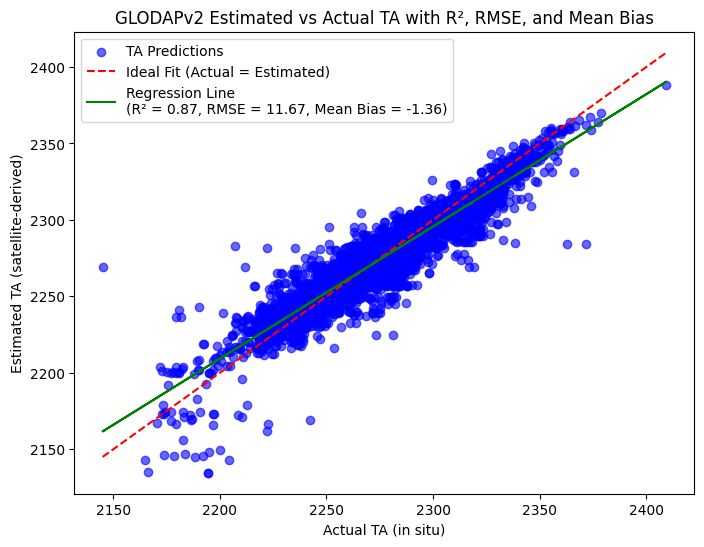

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming y and y_pred are numpy arrays or lists
# Calculate R^2, RMSE, and Mean Bias
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)

# Plotting y vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, label='TA Predictions', color='blue', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit (Actual = Estimated)')

# Plot the linear regression line
m, b = np.polyfit(y, y_pred, 1)  # Fit line to y and y_pred
plt.plot(y, m * np.array(y) + b, color='green', label=f'Regression Line\n(R² = {r2:.2f}, RMSE = {rmse:.2f}, Mean Bias = {mean_bias:.2f})')

# Labels and title
plt.xlabel('Actual TA (in situ)')
plt.ylabel('Estimated TA (satellite-derived)')
plt.title('GLODAPv2 Estimated vs Actual TA with R², RMSE, and Mean Bias')
plt.legend()

# Show plot
plt.show()

In [ ]:
HOT_satellite = satellite_data[(satellite_data['latitude'] == 22.875) & (satellite_data['longitude'] == 202.125)]
HOT_satellite

,latitude,longitude,month,sst,chlor_a,sss,poc,pic,u_wind,v_wind
97537200,22.875,202.125,0,26.305000,0.057464,35.142174,34.399902,0.000092,-5.552091,-7.309467e-01
97537201,22.875,202.125,1,25.760000,0.102148,35.223442,40.199707,0.000024,-7.389859,-3.872861e-01
97537202,22.875,202.125,2,25.180000,0.106645,35.240566,39.600098,0.000020,-8.923004,-1.174736e+00
97537203,22.875,202.125,3,23.725000,0.123680,35.144848,41.000000,0.000020,-8.998958,-1.912788e+00
97537204,22.875,202.125,4,23.535000,0.086657,35.226425,36.199707,0.000016,-5.129163,4.153514e+00
...,...,...,...,...,...,...,...,...,...,...
97537345,22.875,202.125,145,27.289999,0.060268,35.054450,33.799805,0.000092,-5.200000,-9.552245e-16
97537346,22.875,202.125,146,26.234999,0.072551,35.126274,35.399902,0.000038,-8.197190,-2.146510e-01
97537347,22.875,202.125,147,24.824999,0.094533,35.101986,38.399902,0.000036,-7.352603,-2.603693e+00
97537348,22.875,202.125,148,23.670000,0.080072,35.100357,35.199707,0.000054,4.383082,5.712144e+00


In [ ]:
HOTdata = """
2350200222, 092711, 010815,    5.8,  1991.5,  8.087,    -9,
2360200722, 110511, 095852,    5.7,  1989.4,  8.082,  2315,
2370200422, 112911, 084830,    6.0,  1996.1,  8.077,  2318,
2380200622, 122011, 061318,    5.0,  2005.5,  8.071,  2325,
2390200722, 011912, 065446,    5.5,  2007.7,  8.062,  2326,
2400200422, 032512, 183439,    6.4,  2008.6,  8.059,  2322,
2410201223, 050312, 215925,    5.9,  2008.9,  8.055,  2318,
2420201322, 060112, 041458,    4.9,  2005.0,  8.063,  2316,
2430200822, 062712, 162419,    5.7,  2013.1,  8.059,  2325,
2440200722, 080112, 065902,   10.5,  2007.7,  8.065,  2318,
2450200622, 081812, 065730,    4.9,  1999.6,  8.064,  2307,
2460200622, 091512, 070559,    5.7,  1997.8,  8.066,  2307,
2470200622, 100812, 074841,    4.5,  2000.1,  8.066,  2316,
2480200622, 120412, 083046,    7.0,  2015.4,  8.068,  2334,
2490200622, 021313, 071338,    7.3,  2019.5,  8.055,  2331,
2500200722, 030713, 071737,    8.7,  2024.5,  8.050,  2333,
2510200622, 040613, 071006,    5.3,  2029.0,  8.048,  2337,
2520200722, 051813, 071938,    8.8,  1995.5,  8.059,  2301,
2530200722, 062613, 071750,    7.2,  2007.8,  8.063,  2321,
2540200622, 091213, 070930,    7.4,  2009.3,  8.082,  2336,
2550200622, 100213, 070152,    7.5,    -9.0,  8.081,  2323,
2560200622, 102813, 070946,    6.5,  1999.0,  8.081,  2323,
2570200623, 112713, 072318,    6.0,  2008.8,  8.081,  2338,
2580200623, 122113, 071840,    6.7,  2007.8,  8.089,  2336,
2590200623, 011614, 073433,    6.5,  2017.9,  8.068,  2335,
2600200623, 021514, 091648,    6.2,  2018.1,  8.061,  2336,
2610200623, 030614, 071457,    7.5,  2003.4,  8.066,  2321,
2620200623, 041114, 070940,    4.9,  2013.5,  8.064,  2328,
2630200523, 060114, 070217,    4.8,  2003.5,  8.070,  2326,
2640200623, 070114, 071958,    5.3,  2003.2,  8.074,  2323,
2650200623, 091514, 071751,    5.3,  1981.0,  8.083,  2300,
2660200623, 101414, 071924,    5.6,  1979.4,  8.089,  2308,
2670200623, 112214, 071138,    5.0,  1995.9,  8.092,  2325,
2680200623, 121714, 103137,    7.8,  2007.9,  8.073,  2327,
2690200623, 022515, 073446,    4.8,  2005.0,  8.061,  2320,
2700200623, 033015, 125737,    4.5,  2013.4,  8.061,  2325,
2710200622, 042215, 082405,    6.0,  1997.1,  8.067,  2318,
2720200722, 052415, 070942,    4.4,  2006.3,  8.069,  2324,
2730200722, 062015, 072322,    6.4,  1995.2,  8.074,  2310,
2740200722, 072015, 070452,    6.1,  1995.5,  8.075,  2313,
2750200622, 081315, 070720,    4.6,  2001.8,  8.079,  2331,
2770200622, 101415, 065216,    5.7,  1996.8,  8.077,  2320,
2780200522, 111415, 072027,    4.8,  1994.4,  8.084,  2320,
2790200622, 120915, 070430,    4.9,  1982.9,  8.085,  2307,
2800200622, 011316, 071341,    7.9,  1982.8,  8.078,  2305,
2810200622, 021016, 074645,    6.0,  1990.9,  8.076,  2310,
2820200722, 030916, 144214,    6.5,  1995.7,  8.075,  2314,
2830200622, 041516, 071607,    4.9,  1986.7,  8.067,  2299,
2840200422, 052916, 070401,    4.4,  1985.1,  8.073,  2303,
2850200622, 071216, 072610,    7.1,  1985.6,  8.073,  2300,
2860200522, 081016, 070131,    5.2,  1982.2,  8.076,  2301,
2870200622, 101616, 073924,    5.6,  1986.3,  8.078,  2305,
2880200522, 112716, 070233,    6.5,  1996.5,  8.074,  2312,
2890200522, 012417, 083436,    5.2,  2003.0,  8.058,  2307,
2900200124, 022217, 222247,    5.0,    -9.0,  8.064,    -9,
2900200522, 022317, 102623,    5.8,  1994.7,  8.059,  2300,
2900200717, 022317, 164104,    6.0,    -9.0,  8.063,    -9,
2900200916, 022417, 005249,    5.5,    -9.0,  8.064,    -9,
2910200324, 032817, 200346,    5.7,    -9.0,  8.064,    -9,
2910200722, 032917, 114147,    5.9,  1991.5,  8.066,  2304,
2910201524, 033017, 124929,    5.3,    -9.0,  8.067,    -9,
2920200622, 042617, 072147,    4.7,  1987.2,  8.064,  2299,
2930200224, 052317, 195747,    5.3,    -9.0,  8.068,    -9,
2930200622, 052417, 075330,    5.8,  1985.3,  8.069,  2299,
2930201104, 052417, 220236,    5.4,    -9.0,  8.070,    -9,
2940200622, 062117, 080236,    7.7,  1975.9,  8.078,  2287,
2950200622, 080917, 070156,    5.2,  1978.3,  8.084,  2299,
2960200522, 100717, 074107,    7.3,  1987.8,  8.084,  2310,
2970200622, 110917, 071723,    4.6,  1988.3,  8.079,  2312,
2980200622, 121317, 071715,    5.8,  1999.6,  8.067,  2315,
3000200622, 022618, 073916,    6.5,  2000.8,  8.056,  2308,
3010200422, 041818, 071306,    4.8,  2007.5,  8.045,  2315,
3020200522, 051618, 070438,    5.4,  1988.4,  8.057,  2299,
3030200522, 062718, 072316,    7.1,  1978.6,  8.066,  2292,
3040200622, 072518, 071055,    5.6,  1986.4,  8.067,  2303,
3050200622, 091118, 072037,    5.7,  1965.0,  8.079,  2272,
3060200622, 101318, 082323,    5.2,  1987.4, -9.000,  2305,
3070200622, 111718, 085130,    6.1,  2000.1,  8.060,  2318,
3090200622, 011619, 082552,    4.6,  1988.8,  8.069,  2298,
3100200322, 022019, 085017,    7.5,  1994.9,  8.056,  2296,
3110200622, 050319, 073153,    5.7,  1991.6,  8.054,  2292,
3120200622, 061219, 073149,    5.2,  1984.1,  8.062,  2290,
3130200622, 070219, 071741,    4.1,  1966.3,  8.075,  2275,
3140200622, 080319, 071825,    5.5,  1969.4,  8.075,  2276,
3150200622, 090519, 072556,    5.5,  1967.2,  8.084,  2281,
3160200522, 101819, 070131,    5.2,  1979.0,  8.086,  2303,
3170200622, 122019, 073624,    5.4,  1977.0,  8.073,  2287,
3180200322, 010820, 060053,    6.5,  1976.4,  8.074,  2291,
3190200622, 013120, 100443,    7.1,  1984.8,  8.064,  2288,
3200200722, 071620, 070834,    4.9,  1965.8,  8.072,  2275,
3210200122, 080720, 125611,    4.6,  1967.5, -9.000,    -9,
3210200822, 080920, 070008,    4.8,  1962.8,  8.082,  2277,
3220200322, 090220, 130825,    4.7,  1964.8, -9.000,    -9,
3220201022, 090420, 072002,    5.0,  1970.2,  8.084,  2288,
3230200122, 092620, 131936,    4.2,  1966.9, -9.000,    -9,
3230200722, 092820, 070340,    4.7,  1965.7,  8.078,  2282,
3240200122, 111820, 125259,    4.3,  1974.5, -9.000,    -9,
3240200822, 112020, 073121,    5.6,  1973.1,  8.077,  2293,
3250200121, 121820, 125700,    5.5,  1980.5, -9.000,    -9,
3250200622, 121920, 071458,    4.8,  1980.7,  8.066,  2296,
3260200122, 011221, 124813,    4.4,  1989.6, -9.000,    -9,
3260200622, 011321, 070406,    4.9,  1990.7,  8.069,  2306,
3270200122, 021621, 124413,    4.5,  1973.8, -9.000,    -9,
3270200622, 021721, 070705,    4.1,  1983.7,  8.059,  2287,
3280200122, 032321, 131956,    5.4,  1997.4, -9.000,    -9,
3280200522, 032421, 072336,    5.3,  1998.2,  8.049,  2298,
3290200622, 041421, 070729,    4.7,  1993.2,  8.051,    -9,
3300200122, 051621, 130258,    4.5,  1988.5, -9.000,    -9,
3300200622, 051721, 065825,    4.3,  1988.6,  8.051,  2286,
3310200122, 062221, 125705,    7.0,  1985.1, -9.000,    -9,
3310200622, 062321, 070601,    5.3,  1985.2,  8.056,  2288,
3320200522, 071721, 071403,    7.8,  1989.9,  8.061,  2290,
3320200722, 071721, 125707,    5.1,  1983.1, -9.000,    -9,
3330200522, 102921, 130727,    6.7,  2010.6, -9.000,    -9,
3330200922, 103021, 071503,    4.7,  2005.4,  8.064,  2317,
3340200823, 120721, 042222,    6.1,  1972.0,  8.051,  2272,
3350200622, 032822, 072012,    4.6,  2005.4,  8.053,  2308,
3360200622, 052722, 074602,    3.9,  1996.5,  8.046,  2290,
3370200622, 071022, 072543,    4.1,  2017.0,  8.052,  2328,
3380200622, 073122, 073712,    4.2,  2016.9,  8.053,  2324,
3390200722, 090222, 080909,    5.0,  1995.7,  8.063,  2304,
3400200522, 012523, 055232,    4.5,  1999.6,  8.055,  2303,
3410200822, 033123, 083318,    3.3,  2009.9,  8.044,  2303,
3420200822, 052723, 075358,    4.0,  1999.3,  8.035,  2288,
3430200622, 081123, 070649,    4.3,  2002.6,  8.050,  2304,
3440200723, 091623, 211537,    4.3,  2001.7,  8.065,  2312,
3450200422, 100923, 105436,    5.4,  1992.3, -9.000,  2304,
3460200622, 110623, 070716,    5.4,  1999.0,  8.066,  2308,
3470200722, 112923, 072458,    5.1,  2005.8,  8.055,  2308,
3480200622, 122923, 072419,    5.9,  2013.1,  8.043,  2311"""

In [ ]:
from io import StringIO
column_names = ["ID", "Date", "Time", "Pressure", "DIC", "pH", "Alkalinity"]
dtype_dict = {
    "ID": str,
    "Date": str,
    "Time": str
}
# Read the data into a DataFrame
HOT = pd.read_csv(StringIO(HOTdata), header=None, index_col=False, names=column_names, dtype=dtype_dict, skipinitialspace=True)

# Display the DataFrame
HOT

,ID,Date,Time,Pressure,DIC,pH,Alkalinity
0,2350200222,092711,010815,5.8,1991.5,8.087,-9
1,2360200722,110511,095852,5.7,1989.4,8.082,2315
2,2370200422,112911,084830,6.0,1996.1,8.077,2318
3,2380200622,122011,061318,5.0,2005.5,8.071,2325
4,2390200722,011912,065446,5.5,2007.7,8.062,2326
...,...,...,...,...,...,...,...
125,3440200723,091623,211537,4.3,2001.7,8.065,2312
126,3450200422,100923,105436,5.4,1992.3,-9.000,2304
127,3460200622,110623,070716,5.4,1999.0,8.066,2308
128,3470200722,112923,072458,5.1,2005.8,8.055,2308


In [ ]:
HOT['month'] = HOT['Date'].apply(lambda x: (2000 + int(x[4:6]) - 2011) * 12 + int(x[:2]) - 9)

In [ ]:
HOT['latitude'] = 22.875
HOT['longitude'] = 202.125

In [ ]:
HOT.replace(-9, np.nan, inplace=True)

In [ ]:
HOTAlk = HOT[['latitude', 'longitude', 'month', 'Pressure', 'Alkalinity']]

In [ ]:
HOTAlk = HOTAlk.dropna()

In [ ]:
HOTAlk

,latitude,longitude,month,Pressure,Alkalinity
1,22.875,202.125,2,5.7,2315.0
2,22.875,202.125,2,6.0,2318.0
3,22.875,202.125,3,5.0,2325.0
4,22.875,202.125,4,5.5,2326.0
5,22.875,202.125,6,6.4,2322.0
...,...,...,...,...,...
125,22.875,202.125,144,4.3,2312.0
126,22.875,202.125,145,5.4,2304.0
127,22.875,202.125,146,5.4,2308.0
128,22.875,202.125,146,5.1,2308.0


In [ ]:
HOTTAMatchup = pd.merge(HOTAlk, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
HOTTAMatchup

,latitude,longitude,month,Pressure,Alkalinity,sst,chlor_a,sss,poc,pic,u_wind,v_wind
0,22.875,202.125,2,5.7,2315.0,25.180000,0.106645,35.240566,39.600098,0.000020,-8.923004,-1.174736e+00
2,22.875,202.125,3,5.0,2325.0,23.725000,0.123680,35.144848,41.000000,0.000020,-8.998958,-1.912788e+00
3,22.875,202.125,4,5.5,2326.0,23.535000,0.086657,35.226425,36.199707,0.000016,-5.129163,4.153514e+00
4,22.875,202.125,6,6.4,2322.0,22.970000,0.065239,35.127716,32.799805,0.000022,-9.852444,-2.639954e+00
5,22.875,202.125,8,5.9,2318.0,24.060000,0.046687,35.051650,29.399902,0.000038,-7.989036,-4.186876e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
103,22.875,202.125,143,4.3,2304.0,26.660000,0.051853,34.855420,31.399902,0.000052,-7.733270,-1.018104e+00
104,22.875,202.125,144,4.3,2312.0,26.824999,0.058803,34.951560,34.600098,0.000086,-7.789311,-4.082205e-01
105,22.875,202.125,145,5.4,2304.0,27.289999,0.060268,35.054450,33.799805,0.000092,-5.200000,-9.552245e-16
107,22.875,202.125,146,5.1,2308.0,26.234999,0.072551,35.126274,35.399902,0.000038,-8.197190,-2.146510e-01


In [ ]:
HOTTAMatchup = HOTTAMatchup.loc[HOTTAMatchup.groupby('month')['Pressure'].idxmin()]

In [ ]:
X = HOTTAMatchup[['latitude', 'sst', 'sss', 'longitude', 'poc']]
y = HOTTAMatchup['Alkalinity']

In [ ]:
evaluate_model(model, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.0s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(105.95907399471872, 0.5957509023351157, -3.972800201309014)

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.0s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


In [ ]:
y.reset_index(drop=True, inplace=True)

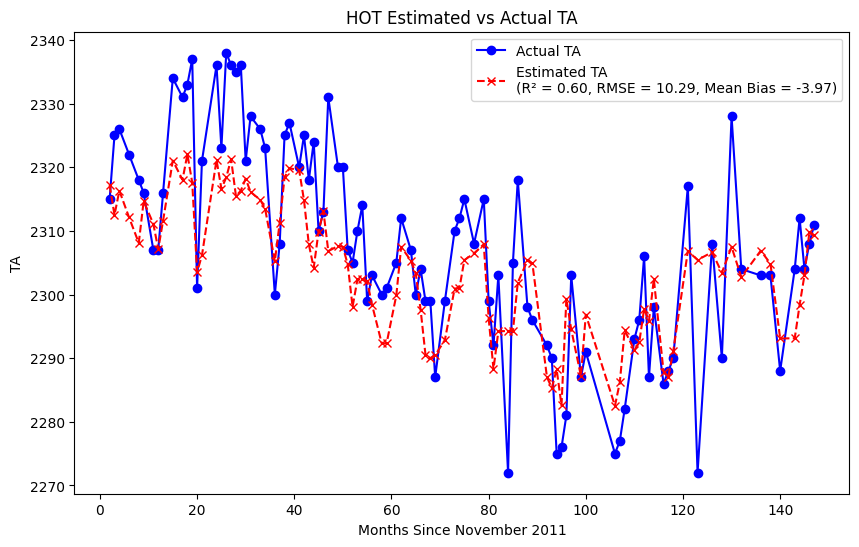

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_pred and y are defined as numpy arrays or lists of predicted and actual values
# If they are pandas series, you can directly use them as well.

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(HOTTAMatchup['month'], y, label='Actual TA', marker='o', linestyle='-', color='b')
plt.plot(HOTTAMatchup['month'], y_pred, label=f'Estimated TA \n(R² = {r2:.2f}, RMSE = {rmse:.2f}, Mean Bias = {mean_bias:.2f})', marker='x', linestyle='--', color='r')

# Adding title and labels
plt.title('HOT Estimated vs Actual TA')
plt.xlabel('Months Since November 2011')
plt.ylabel('TA')

# Show legend
plt.legend()

# Show plot
plt.show()

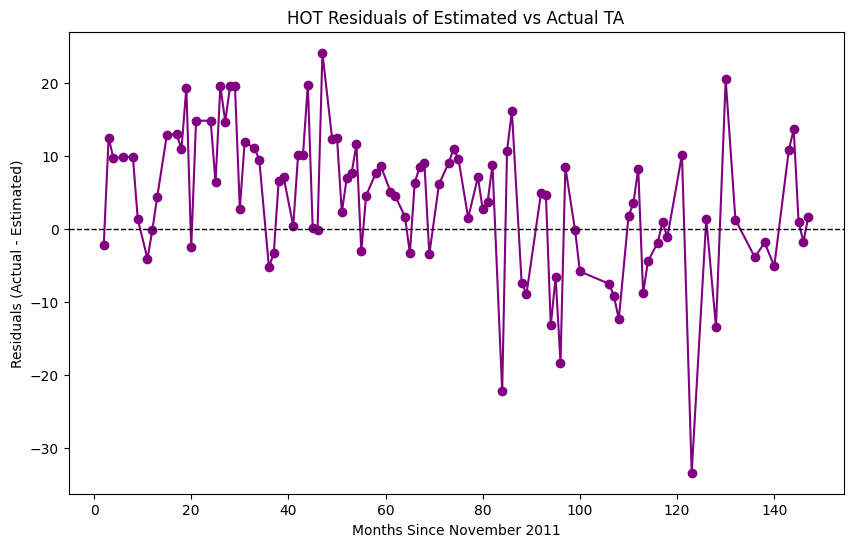

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y and y_pred are defined as numpy arrays, lists, or pandas Series
# Calculate residuals
residuals = y - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.plot(HOTTAMatchup['month'], residuals, marker='o', linestyle='-', color='purple')

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Adding title and labels
plt.title('HOT Residuals of Estimated vs Actual TA')
plt.xlabel('Months Since November 2011')
plt.ylabel('Residuals (Actual - Estimated)')

# Show plot
plt.show()

In [ ]:
dtype_dict = {
    "ID": str,
    "yyyymmdd": str,
}
BATS = pd.read_csv('/content/drive/MyDrive/STS/STSData/bats_bottle.txt', delim_whitespace=True, index_col=False, dtype=dtype_dict)

<ipython-input-43-4005f47a7d05>:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  BATS = pd.read_csv('/content/drive/MyDrive/STS/STSData/bats_bottle.txt', delim_whitespace=True, index_col=False, dtype=dtype_dict)


In [ ]:
BATS

,Id,yyyymmdd,decy,time,latN,lonW,QF,Depth,Temp,CTD_S,...,Bact,POP,TDP,SRP,BSi,LSi,Pro,Syn,Piceu,Naneu
0,1000100112,19881020,1988.80311,2230,31.783,64.116,2,2000.5,3.817,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
1,1000100111,19881020,1988.80311,2230,31.783,64.116,2,2200.3,3.577,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
2,1000100110,19881020,1988.80311,2230,31.783,64.116,2,2398.9,3.317,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
3,1000100109,19881020,1988.80311,2230,31.783,64.116,2,2600.0,3.127,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
4,1000100108,19881020,1988.80311,2230,31.783,64.116,2,2801.7,2.927,-999.000,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69971,1040502020,20230624,2023.47789,1017,31.800,64.744,2,201.1,19.231,36.638,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
69972,1040502021,20230624,2023.47789,1017,31.800,64.744,2,251.4,19.112,36.639,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
69973,1040502022,20230624,2023.47789,1017,31.800,64.744,2,300.8,18.917,36.632,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999
69974,1040502023,20230624,2023.47789,1017,31.800,64.744,2,403.4,18.536,36.584,...,-999.0,-999.0,-999,-999,-999.0,-999.0,-999,-999,-999,-999


In [ ]:
BATS = BATS[['yyyymmdd', 'latN', 'lonW', 'Depth', 'Alk']]
BATS.replace(-999, np.nan, inplace=True)
BATS = BATS.dropna()
BATS['lonW'] = 360 - BATS['lonW']
BATS = BATS.rename(columns={'lonW' : 'longitude', 'latN' : 'latitude'})
BATS['longitude'] = round((BATS['longitude']) / 0.25) * 0.25 + 0.125
BATS['latitude'] = round((BATS['latitude']) / 0.25) * 0.25 + 0.125
BATS['month'] = BATS['yyyymmdd'].apply(lambda x: (int(x[:4]) - 2011) * 12 + int(x[4:6]) - 9)
BATS = BATS[BATS['month'] >= 0]

<ipython-input-45-534bc20369b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BATS.replace(-999, np.nan, inplace=True)


In [ ]:
BATS

,yyyymmdd,latitude,longitude,Depth,Alk,month
40376,20120130,31.875,295.875,5.6,2395.1,4
40378,20120130,31.875,295.875,10.9,2392.5,4
40380,20120130,31.875,295.875,18.6,2398.0,4
40382,20120130,31.875,295.875,40.0,2400.9,4
40384,20120130,31.875,295.875,60.4,2396.9,4
...,...,...,...,...,...,...
69855,20230622,31.875,295.875,599.6,2360.9,141
69858,20230622,31.875,295.875,699.5,2342.4,141
69861,20230622,31.875,295.875,799.6,2330.2,141
69864,20230622,31.875,295.875,900.1,2321.2,141


In [ ]:
BATSTAMatchup = pd.merge(BATS, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
BATSTAMatchup = BATSTAMatchup.loc[BATSTAMatchup.groupby(['month', 'latitude', 'longitude'])['Depth'].idxmin()]
BATSTAMatchup = BATSTAMatchup[BATSTAMatchup['Depth'] <= 30]

In [ ]:
BATSTAMatchup = BATSTAMatchup[(BATSTAMatchup['latitude'] == 31.875) & (BATSTAMatchup['longitude'] == 295.875)]
BATSTAMatchup

,latitude,sst,sss,longitude,poc,Alk,month
0,31.875,20.640000,36.597736,295.875,56.399902,2395.1,4
14,31.875,20.125000,36.607037,295.875,55.199707,2399.2,5
29,31.875,20.154999,36.682854,295.875,47.600098,2395.6,6
58,31.875,20.210000,36.754795,295.875,46.399902,2400.2,7
87,31.875,21.345000,36.668980,295.875,36.000000,2386.2,8
...,...,...,...,...,...,...,...
3858,31.875,20.595000,36.822270,295.875,41.600098,2403.8,137
3894,31.875,20.425000,36.685368,295.875,45.600098,2402.1,138
3954,31.875,21.255000,36.721950,295.875,34.600098,2395.3,139
3982,31.875,21.910000,36.803284,295.875,28.000000,2411.3,140


In [ ]:
BATSTAMatchup = BATSTAMatchup[['latitude', 'sst', 'sss', 'longitude', 'poc', 'Alk', 'month']]
BATSTAMatchup = BATSTAMatchup.dropna()
X = BATSTAMatchup[['latitude', 'sst', 'sss', 'longitude', 'poc']].reset_index(drop=True)
y = BATSTAMatchup['Alk'].reset_index(drop=True)

In [ ]:
evaluate_model(model, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.0s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(116.56611392196417, 0.2742642470424639, -2.672034731625696)

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.0s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


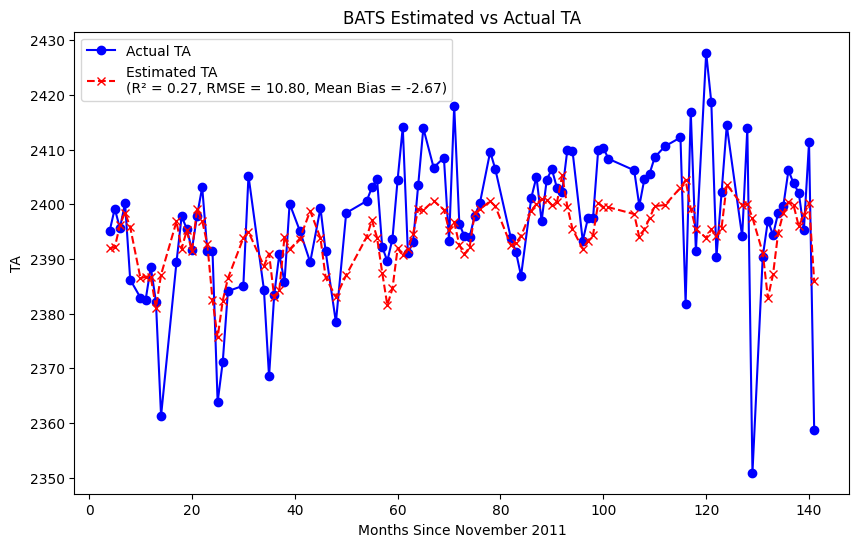

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_pred and y are defined as numpy arrays or lists of predicted and actual values
# If they are pandas series, you can directly use them as well.

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(BATSTAMatchup['month'], y, label='Actual TA', marker='o', linestyle='-', color='b')
plt.plot(BATSTAMatchup['month'], y_pred, label=f'Estimated TA\n(R² = {r2:.2f}, RMSE = {rmse:.2f}, Mean Bias = {mean_bias:.2f})', marker='x', linestyle='--', color='r')

# Adding title and labels
plt.title('BATS Estimated vs Actual TA')
plt.xlabel('Months Since November 2011')
plt.ylabel('TA')

# Show legend
plt.legend()

# Show plot
plt.show()

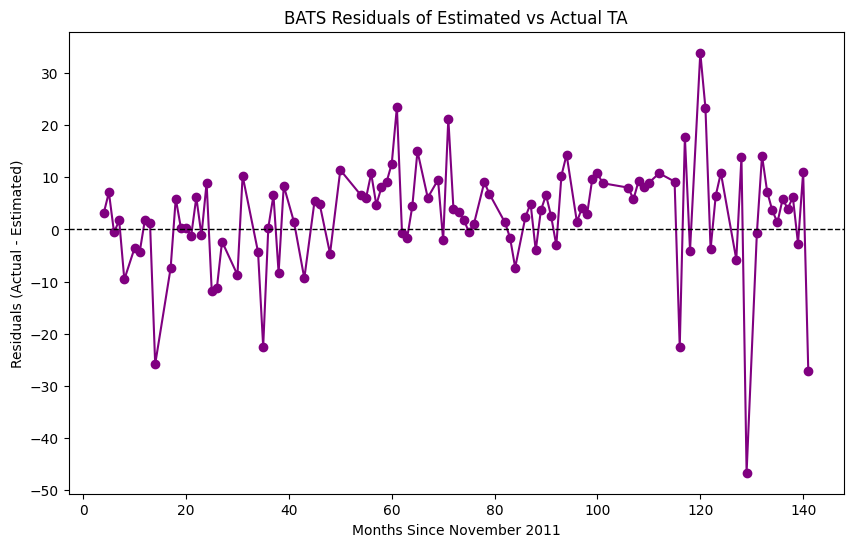

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y and y_pred are defined as numpy arrays, lists, or pandas Series
# Calculate residuals
residuals = y - y_pred

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.plot(BATSTAMatchup['month'], residuals, marker='o', linestyle='-', color='purple')

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Adding title and labels
plt.title('BATS Residuals of Estimated vs Actual TA')
plt.xlabel('Months Since November 2011')
plt.ylabel('Residuals (Actual - Estimated)')

# Show plot
plt.show()

## Basin Analysis

In [ ]:
import netCDF4 as nc
import xarray as xr

# Open the NetCDF file using netCDF4
file_path = '/content/drive/MyDrive/STS/STSData/output_basins.nc'  # Replace with the path to your file
nc_dataset = nc.Dataset(file_path)

# Convert netCDF4.Dataset to xarray.Dataset
xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
basins = xr_dataset.to_dataframe().reset_index()

In [ ]:
basins = basins.rename(columns={'lon' : 'longitude', 'lat' : 'latitude'})

In [ ]:
X = test[['latitude', 'sst', 'sss', 'longitude', 'poc']]
y = test[['talk', 'latitude', 'longitude']]

In [ ]:
!pip install joblib

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_ta.joblib')

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.8s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.9s finished


In [ ]:
y['predictions'] = y_pred

<ipython-input-20-e35c45553dfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = y_pred


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return mse, r2, mean_bias

In [ ]:
def region_accuracy(rgn = -1):
  if rgn != -1:
    merged_df = pd.merge(y, basins, on=['latitude', 'longitude'])
    basin_data = merged_df[merged_df['open_ocean'] == rgn]
  else:
    basin_data = y
  rmse = np.sqrt(mean_squared_error(basin_data['talk'], basin_data['predictions']))
  r2 = r2_score(basin_data['talk'], basin_data['predictions'])
  mean_bias = np.mean(basin_data['predictions'] - basin_data['talk'])
  return rmse, r2, mean_bias, len(basin_data)

In [ ]:
print("RMSE, R2, Bias, n")
print("Atlantic: ", region_accuracy(1))
print("Pacific: ", region_accuracy(2))
print("Indian: ", region_accuracy(3))
print("Arctic: ", region_accuracy(4))
print("Southern: ", region_accuracy(5))
print("Global: ", region_accuracy())

RMSE, R2, Bias, n
Atlantic:  (14.488188679436862, 0.9473653324424004, -1.3254453135824495, 2214608)
Pacific:  (10.510670656767932, 0.9599281061347924, -0.7895549094900518, 4769475)
Indian:  (12.081799521770268, 0.9472417067342054, -0.48802905960651477, 1396544)
Arctic:  (31.296076734239303, 0.9584722075905396, 2.2723601215065723, 156551)
Southern:  (5.700292068563548, 0.9209907493886667, 0.03566271843366764, 2019812)
Global:  (11.81408652034094, 0.9742761997570393, -0.6628055814373316, 10601256)


## Monthly Analysis

In [ ]:
X = test[['latitude', 'sst', 'sss', 'longitude', 'poc']]
y = test[['talk', 'month']]

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_ta.joblib')

In [ ]:
y_pred = model.predict(X)
y['predictions'] = y_pred

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.7s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.7s finished
<ipython-input-25-cdc18176f924>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = y_pred


In [ ]:
def month_accuracy(mn):
  mn = (mn + 4) % 12
  month_data = y[y['month'] % 12 == mn]
  rmse = np.sqrt(mean_squared_error(month_data['talk'], month_data['predictions']))
  r2 = r2_score(month_data['talk'], month_data['predictions'])
  mean_bias = np.mean(month_data['predictions'] - month_data['talk'])
  return rmse, r2, mean_bias, len(month_data)

In [ ]:
print("RMSE, R2, Bias, n")
print("January: ", month_accuracy(0))
print("February: ", month_accuracy(1))
print("March: ", month_accuracy(2))
print("April: ", month_accuracy(3))
print("May: ", month_accuracy(4))
print("June: ", month_accuracy(5))
print("July: ", month_accuracy(6))
print("August: ", month_accuracy(7))
print("September: ", month_accuracy(8))
print("October: ", month_accuracy(9))
print("November: ", month_accuracy(10))
print("December: ", month_accuracy(11))

RMSE, R2, Bias, n
January:  (10.435561831971773, 0.970761926870296, 0.09683325846005245, 953996)
February:  (9.407538278408728, 0.9786803417136651, 0.060657088069759585, 974443)
March:  (10.115773102152618, 0.9764803735478552, -0.732439337452615, 979303)
April:  (10.717980433435613, 0.9760095917613797, -0.486008348153525, 815060)
May:  (11.195021670501937, 0.9769677453566149, -0.5040133977972462, 805060)
June:  (12.375511595975649, 0.9765617235222434, -1.35014207113994, 757177)
July:  (14.645890689502568, 0.9731380370838482, -2.2856468091180604, 788056)
August:  (13.26068715339384, 0.978601663698549, -0.727246630632007, 868261)
September:  (14.728843405551908, 0.9694651333444128, -0.54047936723461, 916138)
October:  (12.143545940560408, 0.9721877753277197, -0.7166889555087561, 935300)
November:  (11.32186181178774, 0.9700422854445463, -0.44543189779724907, 905848)
December:  (10.749882266062452, 0.9701306207844979, -0.7034784309173212, 902614)


In [ ]:
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')

In [ ]:
satellite_data['mn'] = satellite_data['month'] % 12
satellite_data['cmon'] = np.cos(np.deg2rad(satellite_data['mn']))
satellite_data['smon'] = np.sin(np.deg2rad(satellite_data['mn']))
satellite_data['clon'] = np.cos(np.deg2rad(satellite_data['longitude']))
satellite_data['slon'] = np.sin(np.deg2rad(satellite_data['longitude']))
satellite_data['pic/poc'] = satellite_data['pic']/satellite_data['poc']
satellite_data['logchla'] = np.log(satellite_data['chlor_a'] + 1e-5)

In [ ]:
y = satellite_data[['latitude', 'sst', 'sss', 'longitude', 'poc', 'month']]
y = y.dropna()
X = y[['latitude', 'sst', 'sss', 'longitude', 'poc']]
y_pred = model.predict(X)
y['predictions'] = y_pred

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   19.2s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   37.8s finished


In [ ]:
import xarray as xr
import numpy as np

# Open the dataset
ds = xr.open_dataset('/content/drive/MyDrive/STS/STSData/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

talk = ds['talk']

# Select the specific variable 'talk' and time indices from 361 to 480
talk_subset = talk.isel(time=slice(360, 480))  # Python uses zero-based indexing

# Compute the monthly climatology over the selected 10 years
monthly_climatology = talk_subset.groupby('time.month').mean(dim='time')

monthly_climatology = monthly_climatology.assign_coords(
    lon=((monthly_climatology.lon + 360) % 360)
)

# Sort longitudes to ensure proper order
monthly_climatology = monthly_climatology.sortby('lon')

# Define the new high-resolution grid
new_lon = np.arange(0.125, 360, 0.25)
new_lat = np.arange(-89.875, 90, 0.25)

# Interpolate the monthly climatologies onto the new grid
interp_talk = monthly_climatology.interp(lat=new_lat, lon=new_lon, method='linear')

In [ ]:
ten_year = y[(y['month'] >= 4) & (y['month'] <= 123)]

In [ ]:
def month_clim(mn = -1):
  if(mn != -1):
    mn = (mn + 4) % 12
    month_data = ten_year[ten_year['month'] % 12 == mn]
  else:
    month_data = ten_year
  month_data = month_data.dropna()
  monthly_climatology = month_data.groupby(['latitude', 'longitude'])['predictions'].mean().reset_index()
  return monthly_climatology

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'interp_talk' is your observed climatology DataArray from previous steps
# And 'month_clim' is your function that returns predicted climatology for a given month

# Initialize lists to store metrics for each month
r2_list = []
rmse_list = []
mean_bias_list = []
n_list = []

for i in range(12):
    # **1. Get Predicted Climatology for Month i**
    # Call your function 'month_clim' to get the predicted climatology for month i
    pred_clim = month_clim(i)  # Should return a pandas DataFrame

    # Ensure 'pred_clim' has columns 'lat', 'lon', 'talk_pred'
    if 'predictions' in pred_clim.columns:
        pred_clim = pred_clim.rename(columns={'predictions': 'talk_pred'})


    # **3. Get Observed Climatology for Month i+1**
    # 'interp_talk' uses months from 1 to 12
    observed_clim = interp_talk.sel(month=i+1)

    # Convert the observed DataArray to a DataFrame
    observed_clim_df = observed_clim.to_dataframe(name='talk_obs').reset_index().dropna()
    observed_clim_df = observed_clim_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
    observed_clim_df['longitude'] = (observed_clim_df['longitude'] + 360) % 360

    # **4. Merge Predicted and Observed DataFrames on 'lat' and 'lon'**
    merged_df = pd.merge(pred_clim, observed_clim_df, on=['latitude', 'longitude'])

    merged_df = merged_df.dropna()
    # **5. Compute Metrics**
    # R² Score
    r2 = r2_score(merged_df['talk_obs'], merged_df['talk_pred'])

    # Root Mean Squared Error (rmse)
    rmse = np.sqrt(mean_squared_error(merged_df['talk_obs'], merged_df['talk_pred']))

    # Mean Bias (Mean of Differences)
    mean_bias = np.mean(merged_df['talk_pred'] - merged_df['talk_obs'])

    n = len(merged_df)

    # print(r2, rmse, mean_bias, n)
    # **6. Store Metrics**
    r2_list.append(r2)
    rmse_list.append(rmse)
    mean_bias_list.append(mean_bias)
    n_list.append(n)

# **7. Compile Results into a DataFrame**
metrics_df = pd.DataFrame({
    'Month': range(1, 13),
    'R²': r2_list,
    'rmse': rmse_list,
    'Mean Bias': mean_bias_list,
    'n': n_list
})

# **8. Display the Results**
print(metrics_df)

    Month        R²       rmse  Mean Bias       n
0       1  0.939545  13.262887  -2.255249  513798
1       2  0.949038  13.087750  -2.439065  530504
2       3  0.957214  12.005099  -2.121998  530468
3       4  0.957296  12.564729  -2.885448  491382
4       5  0.950776  14.637071  -3.210216  435897
5       6  0.939207  20.463720  -3.421818  415518
6       7  0.933715  27.276469  -0.909814  440723
7       8  0.931295  28.004409   0.066120  490855
8       9  0.934574  24.892367  -0.719223  508565
9      10  0.958202  13.158332  -2.194631  488610
10     11  0.944181  13.562239  -2.313936  477237
11     12  0.953519  11.657045  -1.967344  490362


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Open the dataset
ds = xr.open_dataset('/content/drive/MyDrive/STS/STSData/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

# Select the specific variable 'talk' and time indices from 361 to 480
talk_subset = ds['talk'].isel(time=slice(360, 480))  # Zero-based indexing

# Compute the full climatology over the selected 10-year period
full_climatology = talk_subset.mean(dim='time')

full_climatology = full_climatology.assign_coords(
    lon=((full_climatology.lon + 360) % 360)
)

# Sort longitudes to ensure proper order
full_climatology = full_climatology.sortby('lon')

# Define the new high-resolution grid
new_lon = np.arange(0.125, 360, 0.25)
new_lat = np.arange(-89.875, 90, 0.25)

# Interpolate the full climatology onto the new grid
interp_full_climatology = full_climatology.interp(lat=new_lat, lon=new_lon)

# Convert to DataFrame
full_climatology_df = interp_full_climatology.to_dataframe(name='talk_obs').reset_index().dropna()
full_climatology_df = full_climatology_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
# full_climatology_df['longitude'] = (full_climatology_df['longitude'] + 360) % 360

In [ ]:
full_climatology_df.max()

,0
latitude,86.37500
longitude,359.37500
talk_obs,2675.21693


In [ ]:
pred_clim = month_clim()
merged_df = pd.merge(pred_clim, full_climatology_df, on=['latitude', 'longitude']).dropna()
merged_df['TA Differences With GRaCER'] = merged_df['predictions'] - merged_df['talk_obs']

In [ ]:
ds = merged_df.set_index(['latitude', 'longitude']).to_xarray()
ds.to_netcdf('climatological_diff.nc')

In [ ]:
merged_df.min()

,0
latitude,-77.375000
longitude,0.625000
predictions,1091.021063
talk_obs,1196.634186
TA Differences With GRaCER,-386.780086
